In [1]:
# Importing all required libraries

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import missingno as msno
from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.linear_model import LinearRegression
from dpp.data import load_from_kaggle

/Users/ebbykuriakose/Desktop/Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download a dataset from Kaggle and save it to the local raw data folder.
# The dataset name is extracted automatically from the Kaggle link.

dataset_link = "gagandeep16/car-sales" # replace with your dataset link from Kaggle 
destination = "../data/raw"
dataset_name = dataset_link.split("/")[-1]

# download dataset and return list of file paths
files = load_from_kaggle(
    dataset_link=dataset_link, 
    destination=destination,
    )

Destination directory '../data/raw/car-sales' already exists with files. Skipping download (replace=False).


In [3]:
files

['Car_sales.csv']

In [4]:
# Load and Preview Dataset
df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))
df.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [5]:
# Dataset overview: shape, summary stats, and duplicates
display(
    "Shape",
    df.shape,
    "Description",
    df.describe().round(2),
    "Duplicates",
    df.duplicated().sum(),
)

# Column-level details: data types, missing values, unique counts, and sample values
pd.DataFrame(
    {
        "Data Types": df.dtypes,
        "Unique Values": df.nunique(),
        "Sample Values": [df[col].sample(3).tolist() for col in df.columns]
    })

'Shape'

(157, 16)

'Description'

,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.00,121.00,155.00,156.00,156.00,156.00,156.00,156.00,155.00,156.00,154.00,155.00
mean,53.00,18.07,27.39,3.06,185.95,107.49,71.15,187.34,3.38,17.95,23.84,77.04
std,68.03,11.45,14.35,1.04,56.70,7.64,3.45,13.43,0.63,3.89,4.28,25.14
min,0.11,5.16,9.24,1.00,55.00,92.60,62.60,149.40,1.90,10.30,15.00,23.28
25%,14.11,11.26,18.02,2.30,149.50,103.00,68.40,177.58,2.97,15.80,21.00,60.41
50%,29.45,14.18,22.80,3.00,177.50,107.00,70.55,187.90,3.34,17.20,24.00,72.03
75%,67.96,19.88,31.95,3.58,215.00,112.20,73.43,196.12,3.80,19.58,26.00,89.41
max,540.56,67.55,85.50,8.00,450.00,138.70,79.90,224.50,5.57,32.00,45.00,188.14


'Duplicates'

np.int64(0)

,Data Types,Unique Values,Sample Values
Manufacturer,object,30,"[Mercury, Toyota, Dodge]"
Model,object,156,"[LS400, CR-V, Maxima]"
Sales_in_thousands,float64,157,"[26.232, 63.403, 14.351]"
__year_resale_value,float64,117,"[17.81, nan, 13.725]"
Vehicle_type,object,2,"[Passenger, Car, Car]"
Price_in_thousands,float64,152,"[39.08, 13.108, 14.999]"
Engine_size,float64,31,"[2.5, 3.0, 3.0]"
Horsepower,float64,66,"[180.0, 140.0, 185.0]"
Wheelbase,float64,88,"[94.9, 95.2, 105.0]"
Width,float64,78,"[66.7, 73.6, 70.1]"


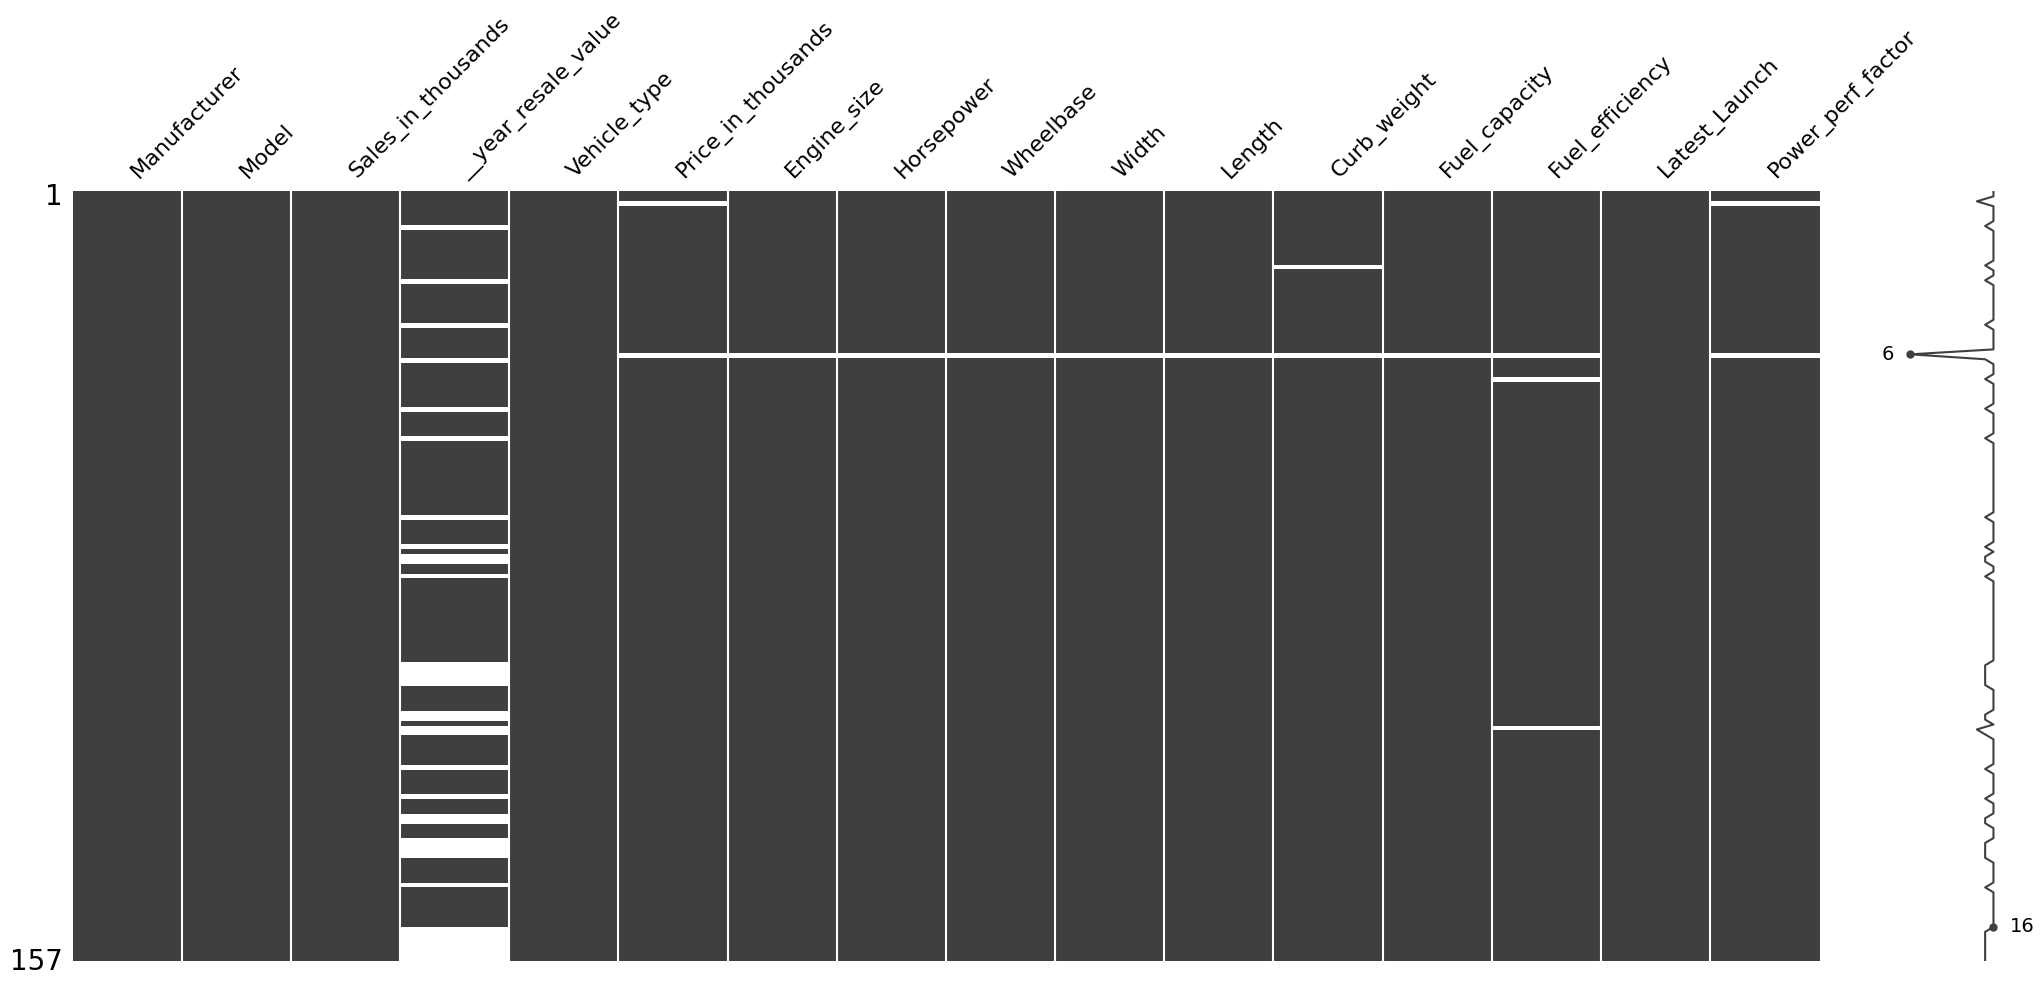

In [6]:
# Visualizing missing values in the dataset
msno.matrix(df)
plt.show()

In [7]:
# Rename column '__year_resale_value' to 'Year_resale_value' if it exists
if "__year_resale_value" in df.columns:
    df.rename(columns={"__year_resale_value": "Year_resale_value"}, inplace=True)

In [8]:
# Converted specified columns to categorical type
category_col = ["Manufacturer","Model","Vehicle_type"]
for col in category_col:
    df[col] = df[col].astype("category")

# Convert the 'Latest_Launch' column from string format MM/DD/YYYY to datetime objects.
df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'], format='%m/%d/%Y', errors='coerce')

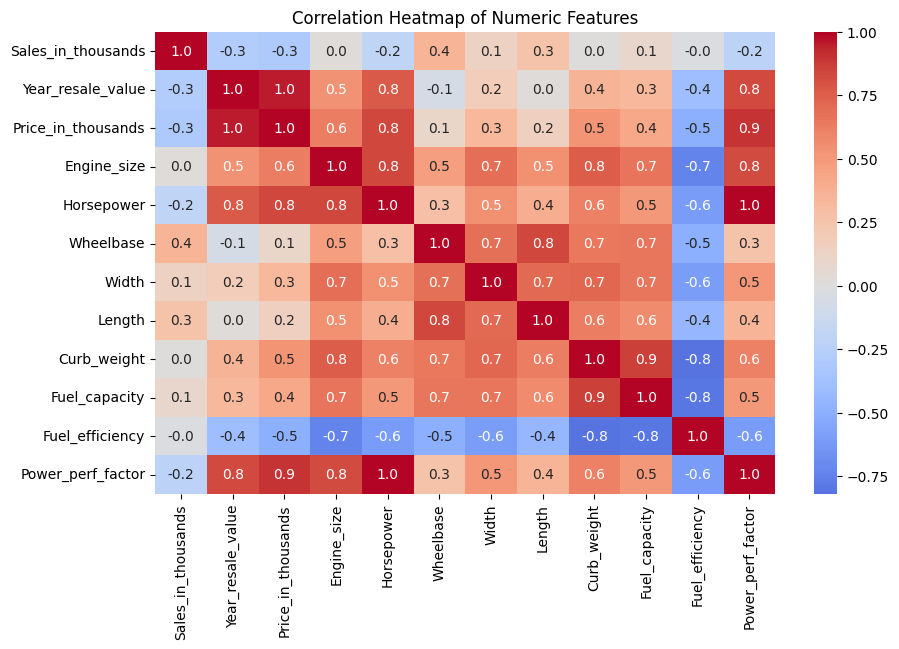

In [9]:
# Plot a heatmap of correlations between numeric features
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, fmt='.1f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [10]:
# Keep only rows that have fewer than 3 missing (NaN) values
df = df[df.isna().sum(axis=1) < 3]

In [11]:
# Extracts highly correlated columns for each numeric feature.
corr_matrix = df.corr(numeric_only=True).abs() 
threshold = 0.6

# Create a boolean mask of correlations above threshold (excluding diagonal)
mask = (corr_matrix > threshold) & (~np.eye(corr_matrix.shape[0], dtype=bool))

# Extract dependent columns as a dictionary
dependent_columns = {col: list(corr_matrix.columns[mask[col]]) for col in corr_matrix.columns}

# Convert dictionary to a DataFrame (simplest method)
dependent_df = pd.DataFrame(list(dependent_columns.items()), columns=['Column', 'Dependent Columns'])

# Show full content
pd.set_option('display.max_colwidth', None)
print(dependent_df)

                Column  \
0   Sales_in_thousands   
1    Year_resale_value   
2   Price_in_thousands   
3          Engine_size   
4           Horsepower   
5            Wheelbase   
6                Width   
7               Length   
8          Curb_weight   
9        Fuel_capacity   
10     Fuel_efficiency   
11   Power_perf_factor   

                                                                                          Dependent Columns  
0                                                                                                        []  
1                                                       [Price_in_thousands, Horsepower, Power_perf_factor]  
2                                           [Year_resale_value, Engine_size, Horsepower, Power_perf_factor]  
3   [Price_in_thousands, Horsepower, Width, Curb_weight, Fuel_capacity, Fuel_efficiency, Power_perf_factor]  
4     [Year_resale_value, Price_in_thousands, Engine_size, Curb_weight, Fuel_efficiency, Power_perf_factor]  
5

In [12]:
# Filled missing values in 'Price_in_thousands' and 'Power_perf_factor' with their respective medians
df["Price_in_thousands"] = df["Price_in_thousands"].fillna(df["Price_in_thousands"].median())
df["Power_perf_factor"] = df["Power_perf_factor"].fillna(df["Power_perf_factor"].median())

In [13]:
# Function to impute missing values in numeric columns using Linear Regression 
# (predicts missing target values from related features and updates the dataframe)

def impute_with_regression(df, target_col, features):
    """
    Impute missing values in target_col using Linear Regression on given features.
    """
    # Split data into rows with and without target_col
    train_data = df[df[target_col].notnull()]
    test_data = df[df[target_col].isnull()]
    
    # If there are no missing values, just return
    if test_data.empty:
        print(f"No missing values in {target_col}")
        return df
    
    # Save indices of missing rows
    missing_idx = test_data.index
    
    # Prepare training data
    X_train = train_data[features]
    y_train = train_data[target_col]
    
    # Train regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_test = test_data[features]
    predicted_values = model.predict(X_test)
    
    # Assign predictions back
    df.loc[missing_idx, target_col] = predicted_values
    
    #print(f"Rows imputed in '{target_col}':")
    #display(df.loc[missing_idx])
    
    return df


In [14]:
# Impute missing values for multiple columns using the defined regression function

# Define features (you can adjust per target column if needed)
features_curb_weight = ["Length", "Width", "Engine_size", "Horsepower", "Wheelbase", "Fuel_capacity"]
features_fuel_efficiency = ["Length", "Width", "Engine_size", "Horsepower", "Wheelbase", "Fuel_capacity"]
features_resale_value = ["Length", "Width", "Engine_size", "Horsepower", "Wheelbase", "Fuel_capacity"]

# Call the function for each column
df = impute_with_regression(df, "Curb_weight", features_curb_weight)
df = impute_with_regression(df, "Fuel_efficiency", features_fuel_efficiency)
df = impute_with_regression(df, "Year_resale_value", features_resale_value)


Column: Sales_in_thousands
Skewness: 3.40
Highly right-skewed


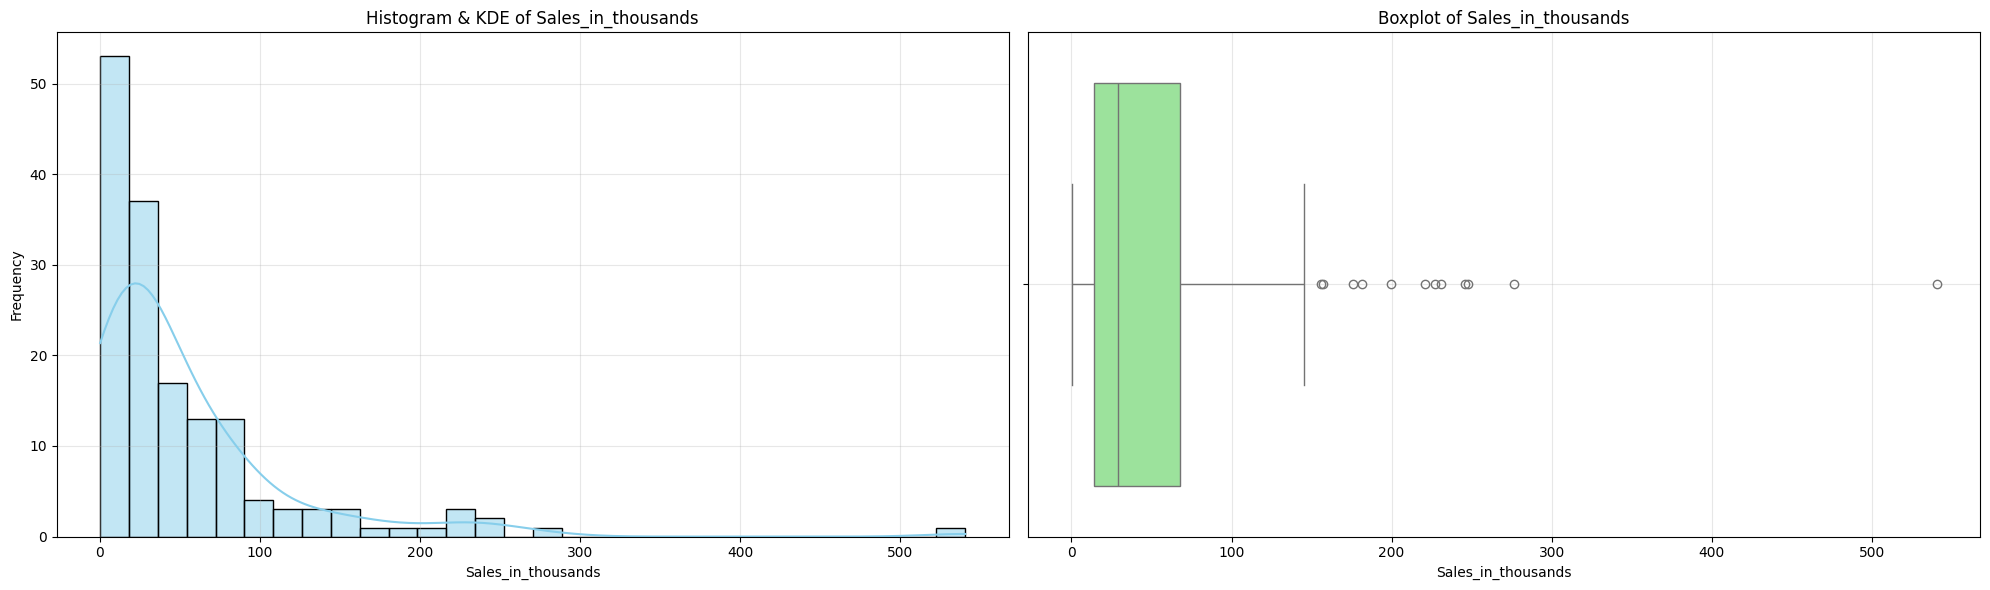


Column: Year_resale_value
Skewness: 1.88
Highly right-skewed


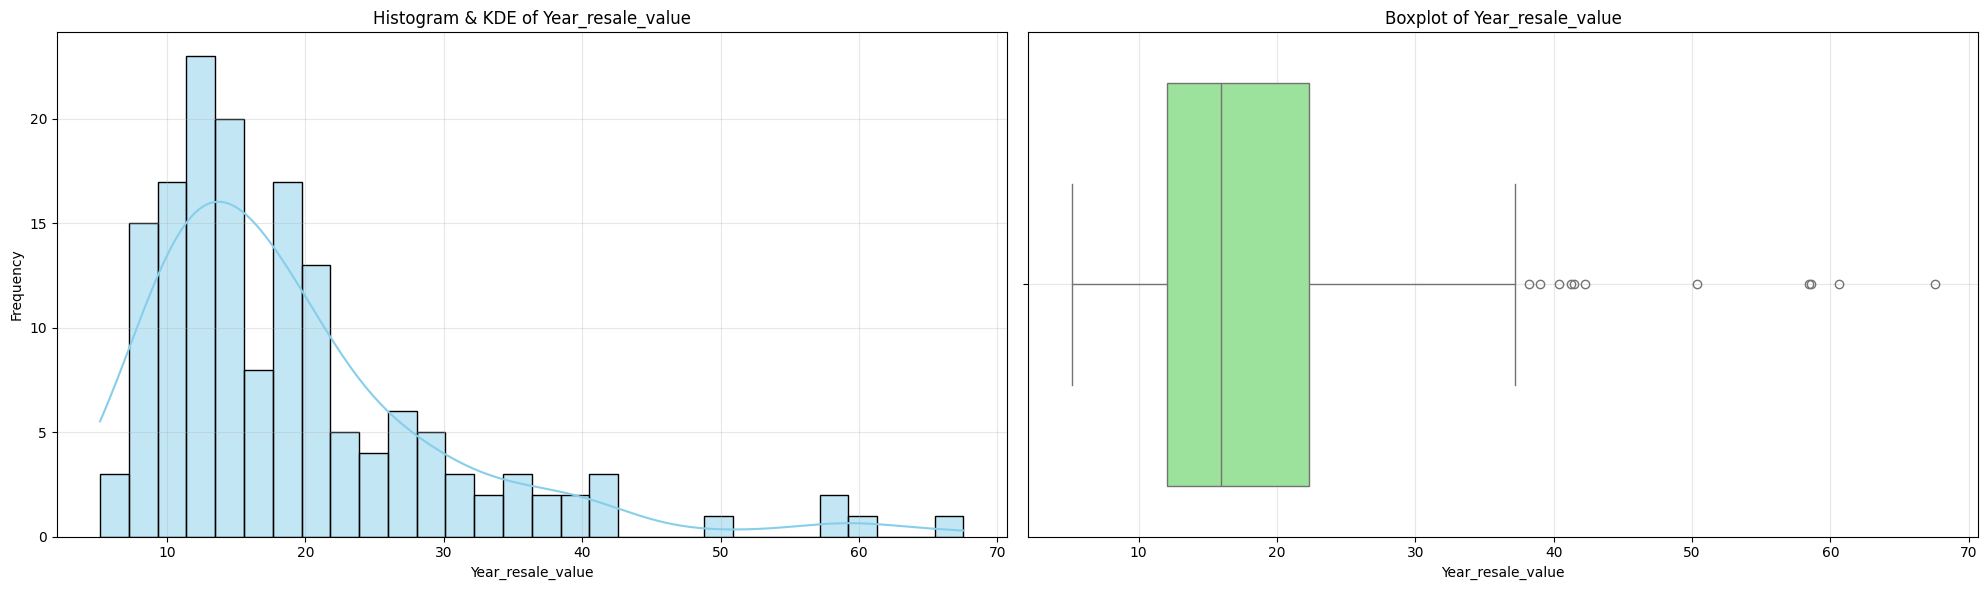


Column: Price_in_thousands
Skewness: 1.78
Highly right-skewed


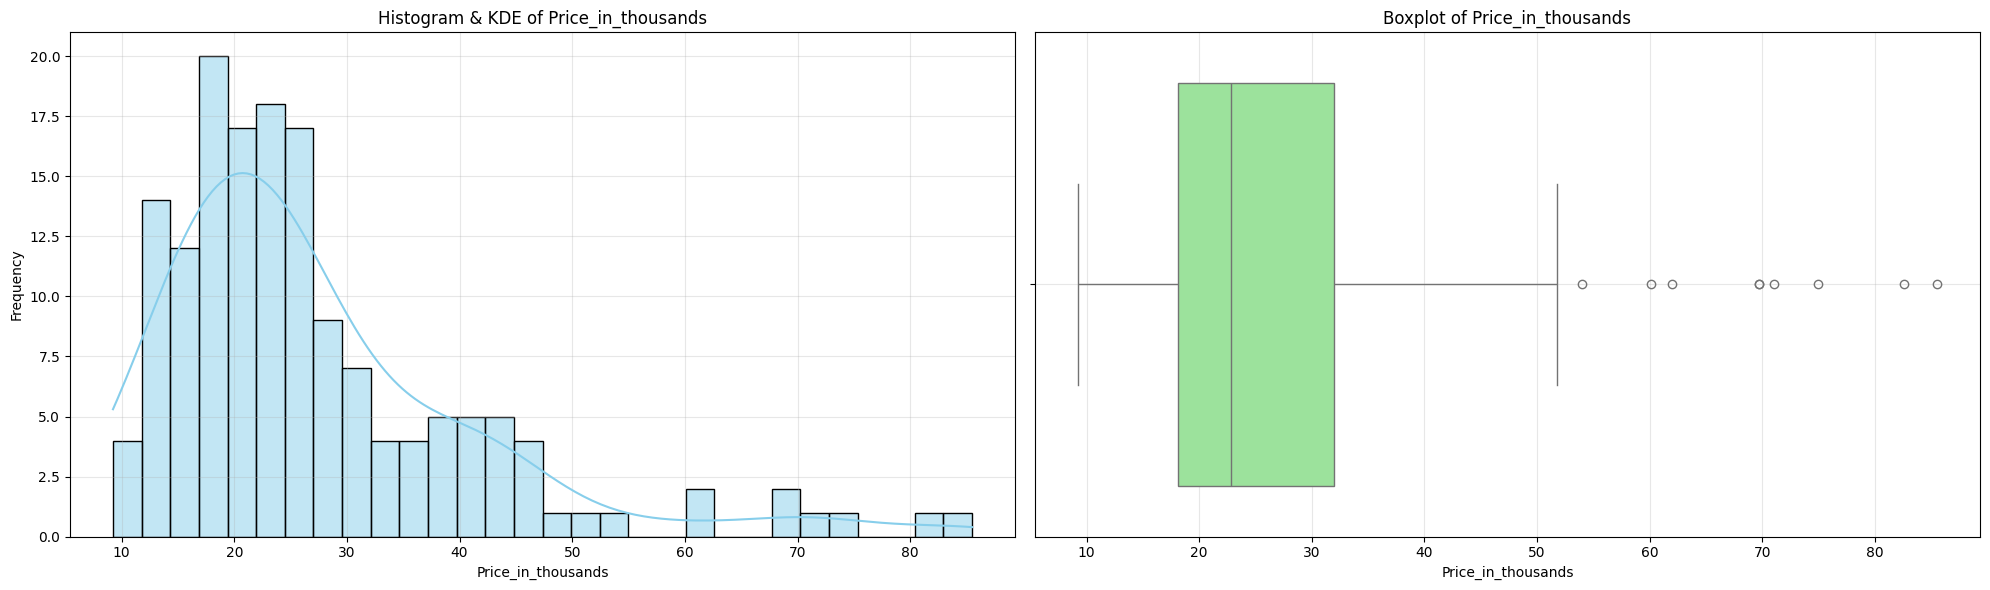


Column: Engine_size
Skewness: 1.10
Highly right-skewed


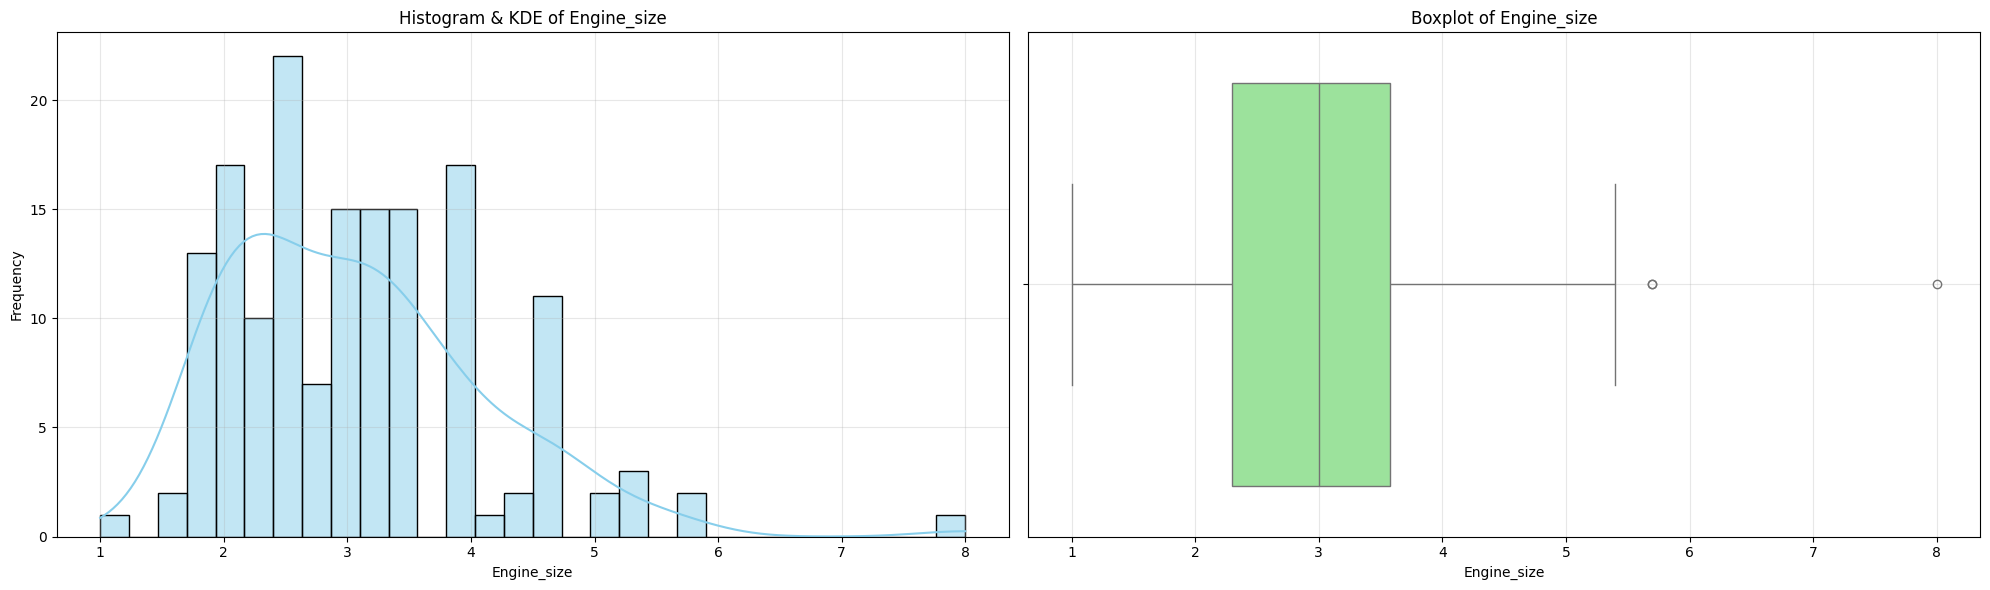


Column: Horsepower
Skewness: 1.00
Highly right-skewed


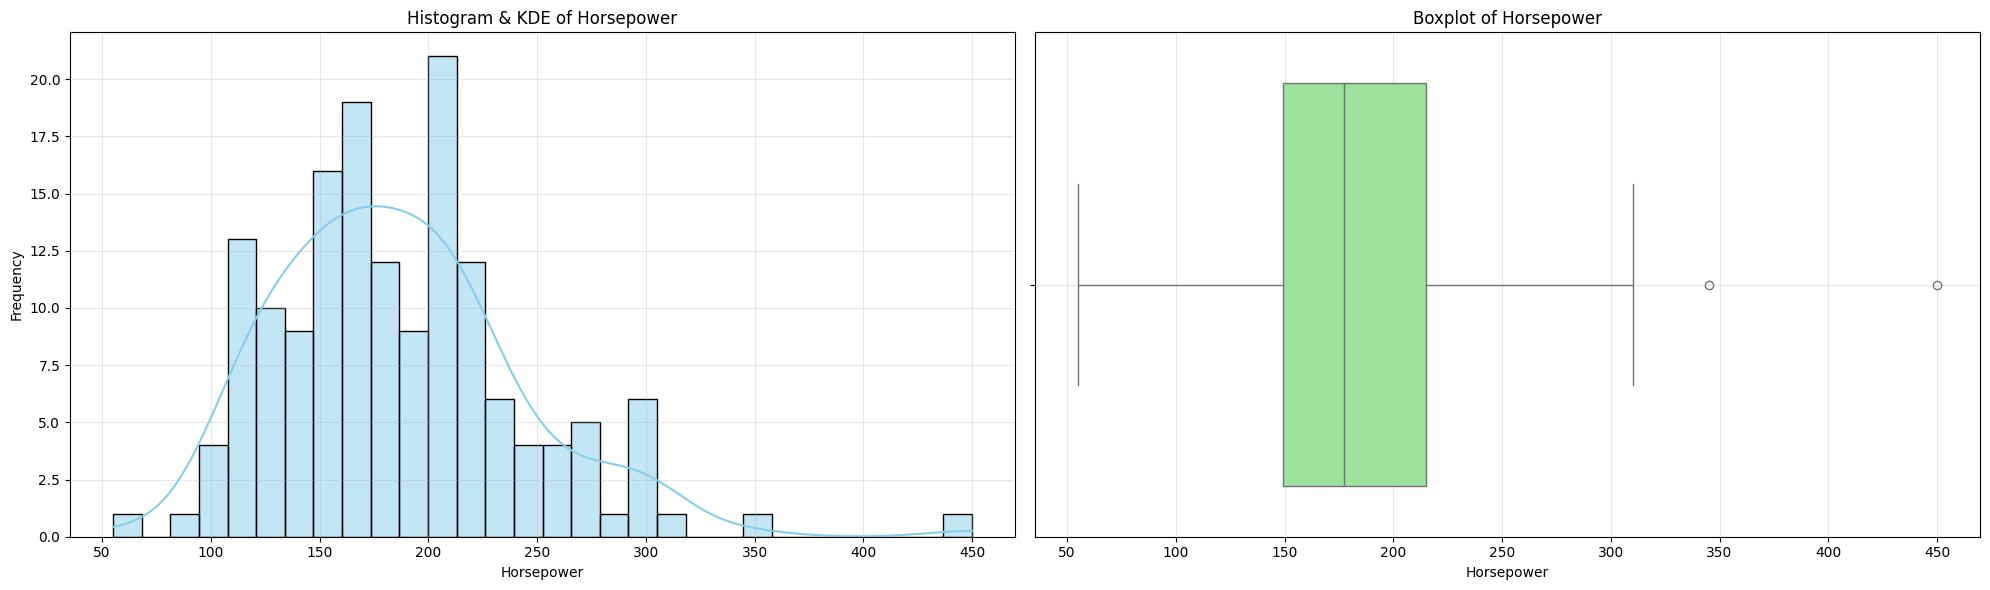


Column: Wheelbase
Skewness: 0.97
Moderately right-skewed


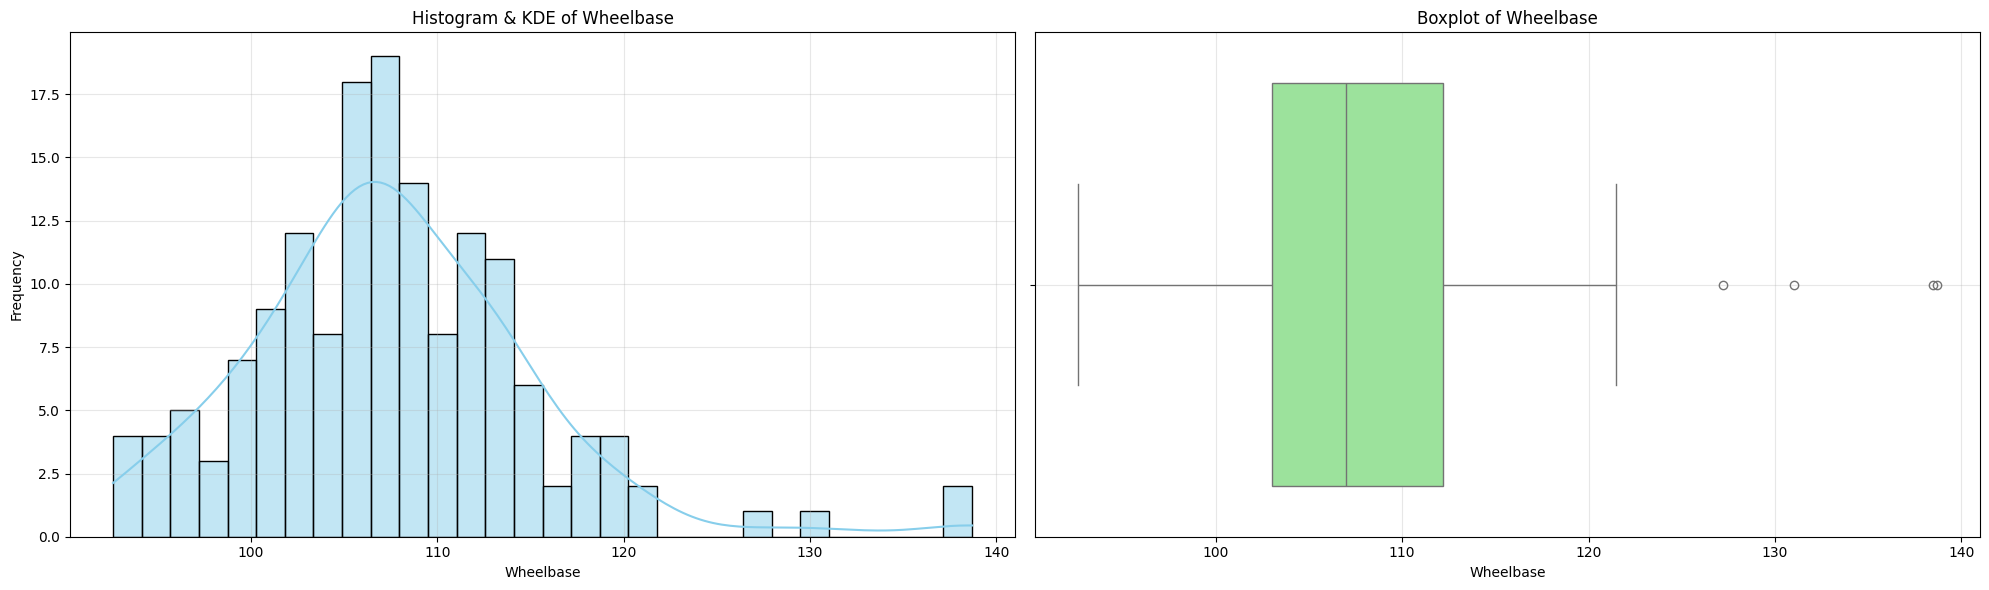


Column: Width
Skewness: 0.48
Approximately symmetric


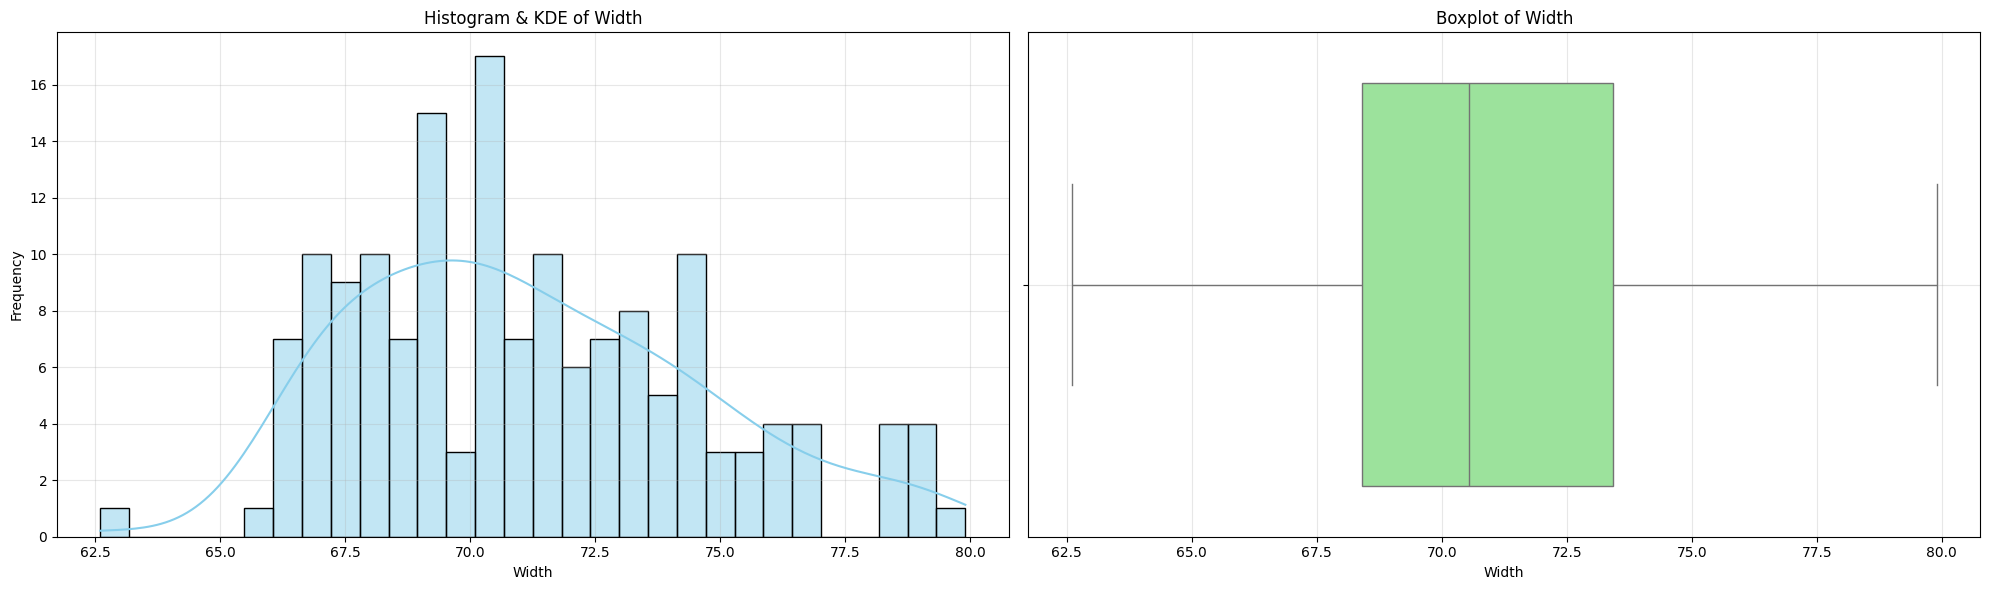


Column: Length
Skewness: -0.06
Approximately symmetric


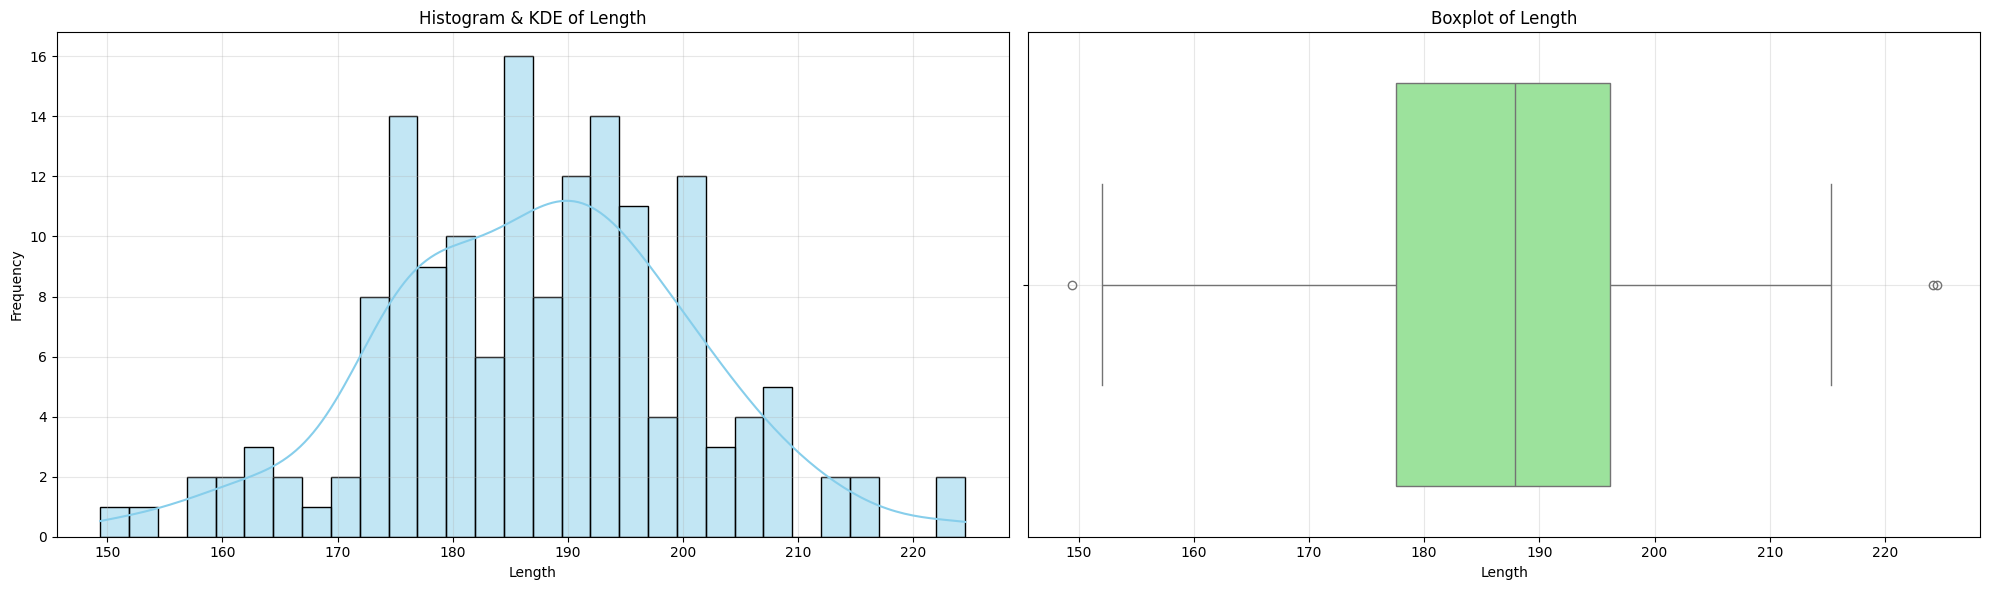


Column: Curb_weight
Skewness: 0.70
Moderately right-skewed


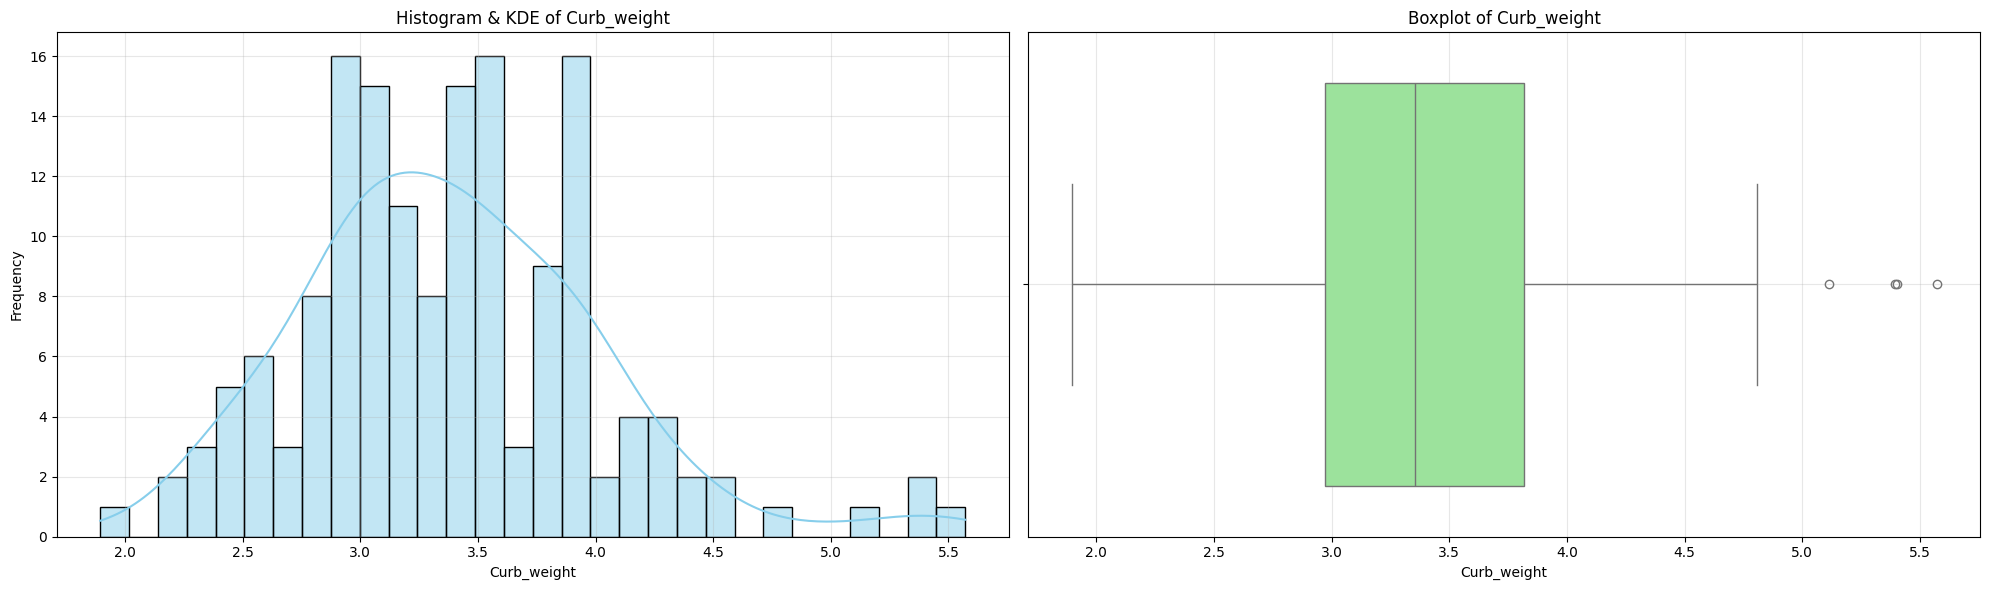


Column: Fuel_capacity
Skewness: 1.14
Highly right-skewed


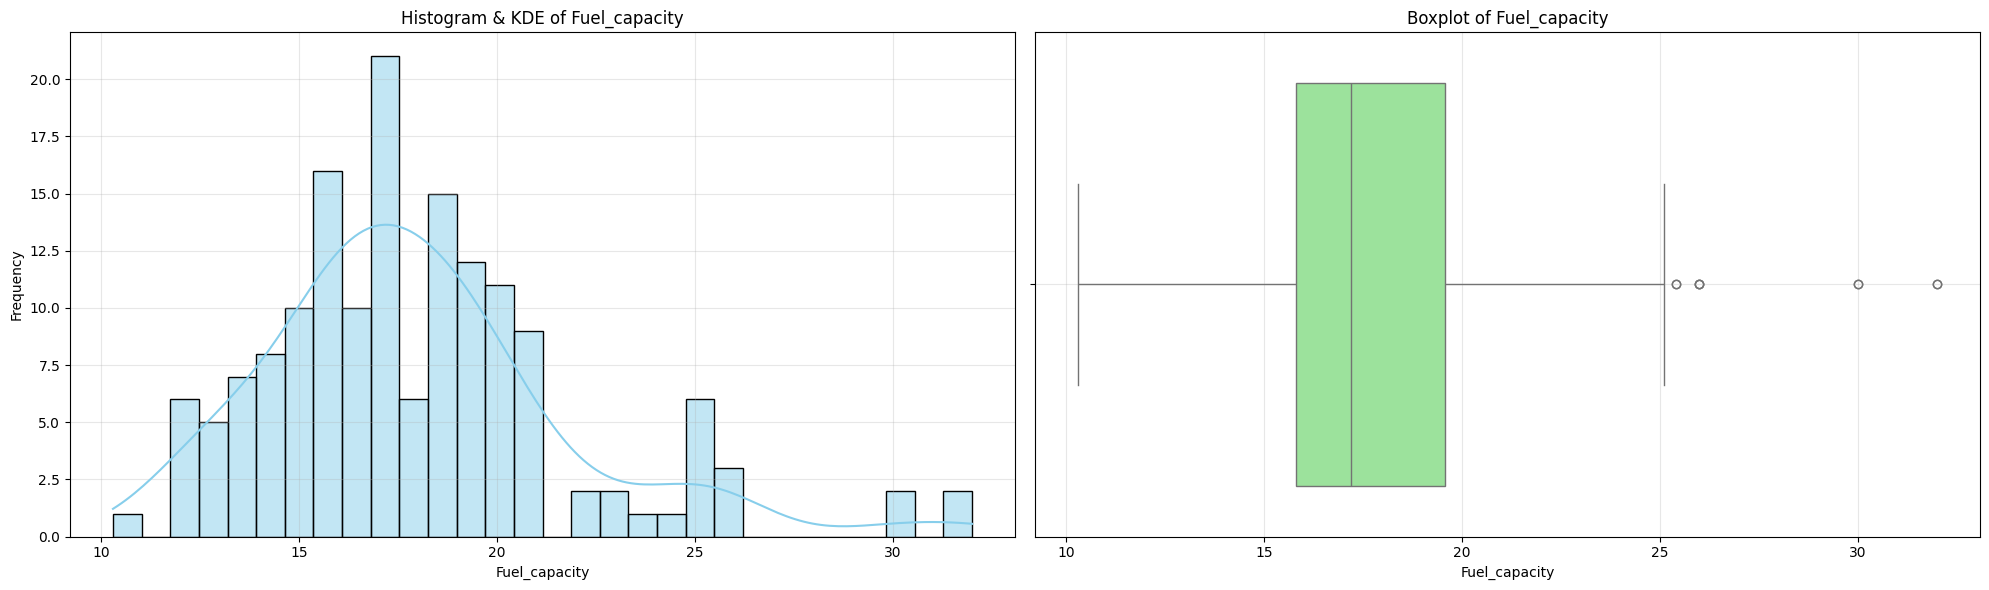


Column: Fuel_efficiency
Skewness: 0.69
Moderately right-skewed


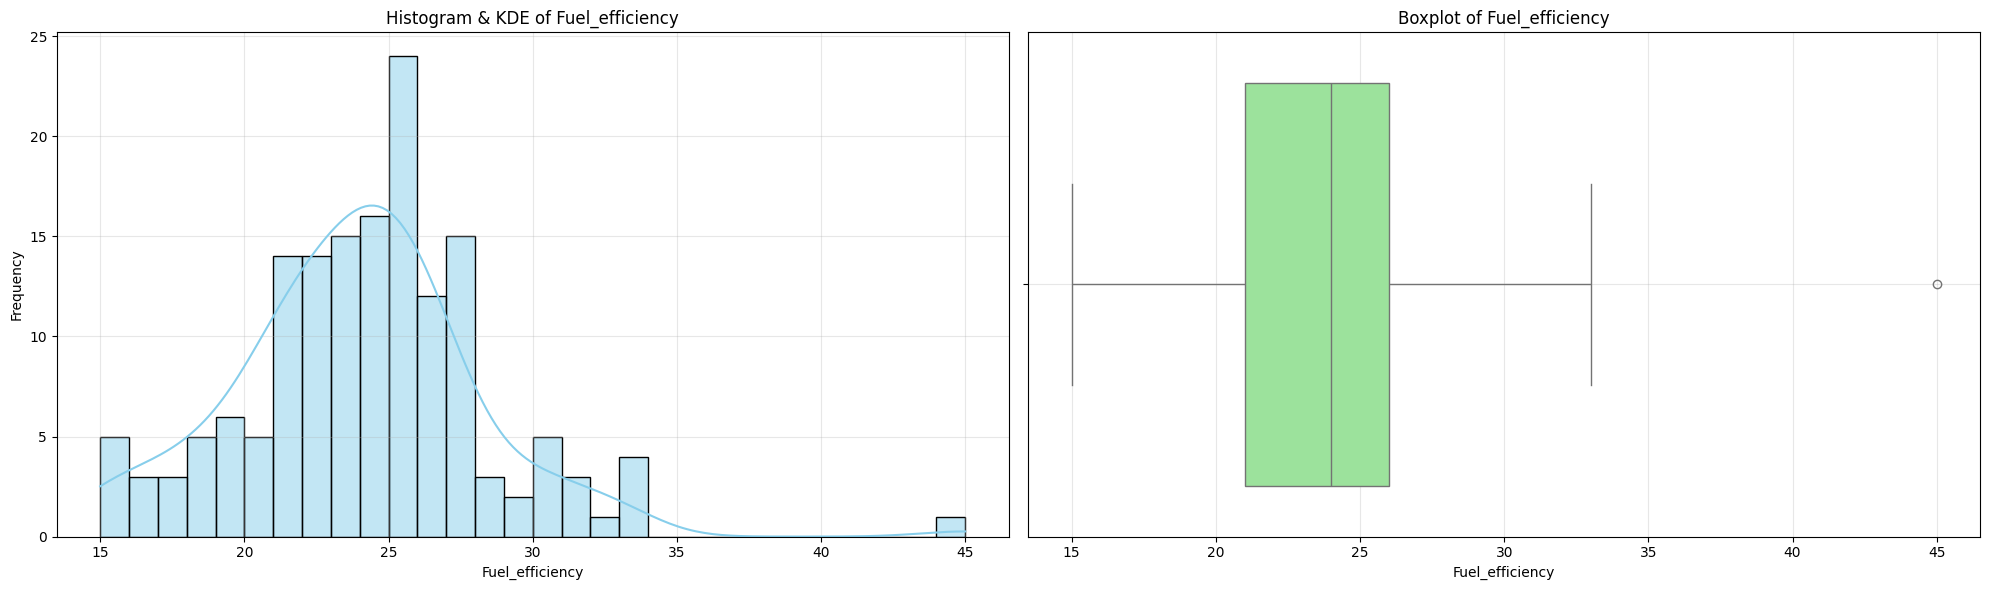


Column: Power_perf_factor
Skewness: 1.08
Highly right-skewed


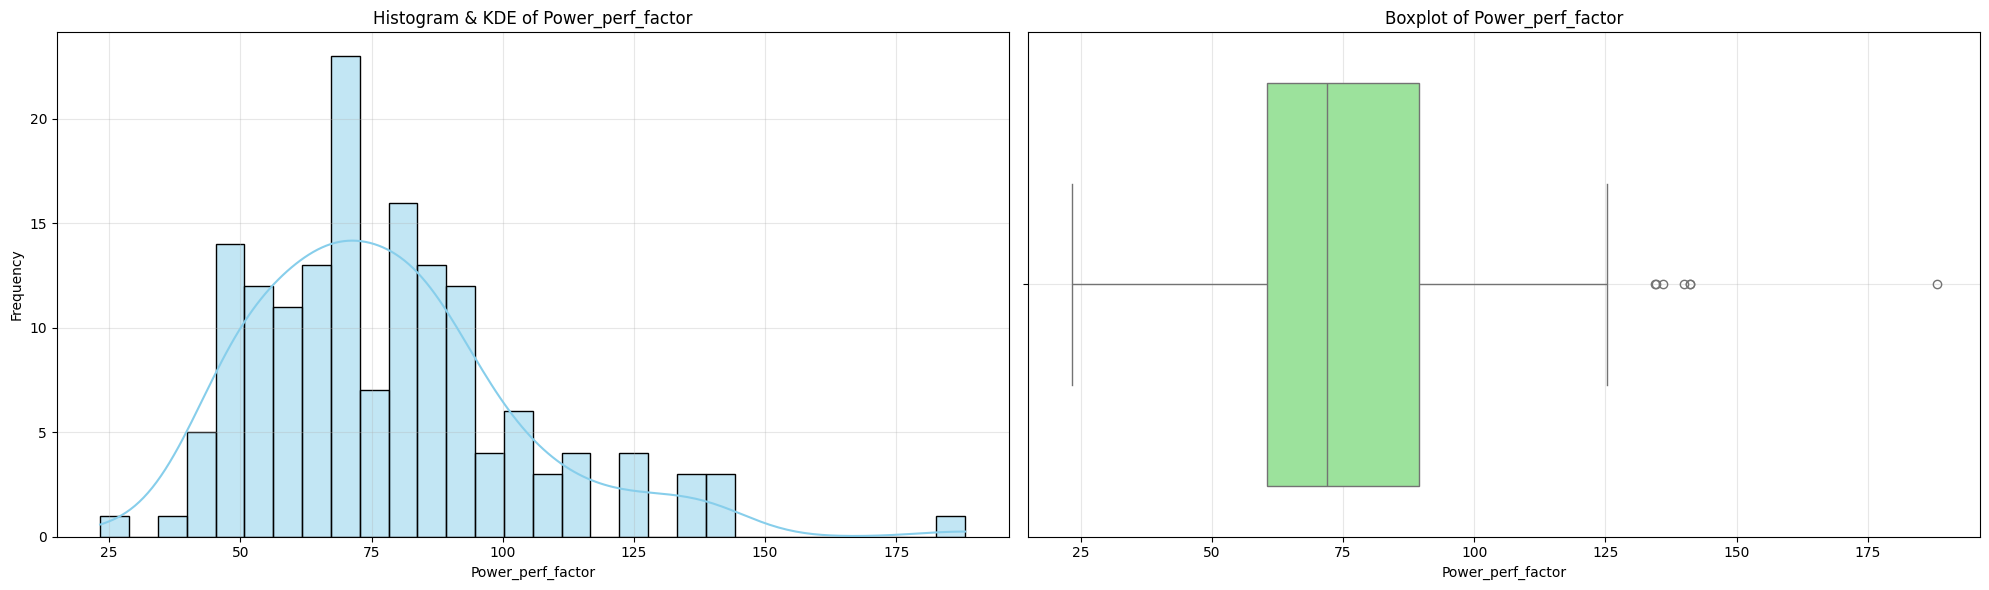

In [15]:
# Univariate Analysis - Numeric Columns
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    skewness = df[col].skew()
    print(f"\nColumn: {col}")
    print(f"Skewness: {skewness:.2f}")
    
    if skewness > 1:
        print("Highly right-skewed")
    elif skewness > 0.5:
        print("Moderately right-skewed")
    elif skewness < -1:
        print("Highly left-skewed")
    elif skewness < -0.5:
        print("Moderately left-skewed")
    else:
        print("Approximately symmetric")
    
    plt.figure(figsize=(20,6))
    
    # Histogram with KDE
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Histogram & KDE of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)

    # --- Boxplot for outlier detection ---
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.grid(alpha=0.3)
    
    # Display the plots
    plt.tight_layout()
    plt.show()


Column: Manufacturer


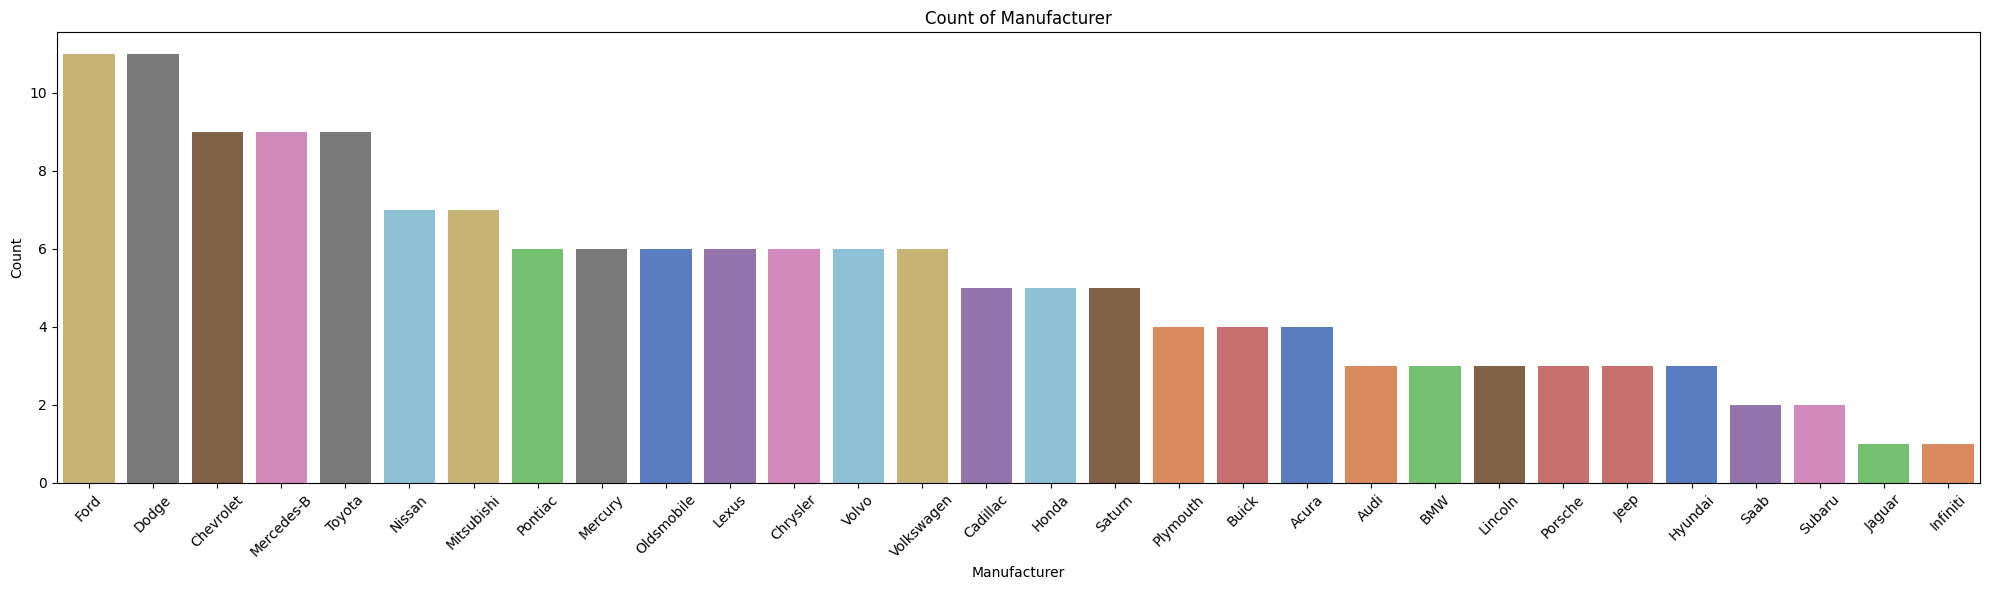


Column: Model


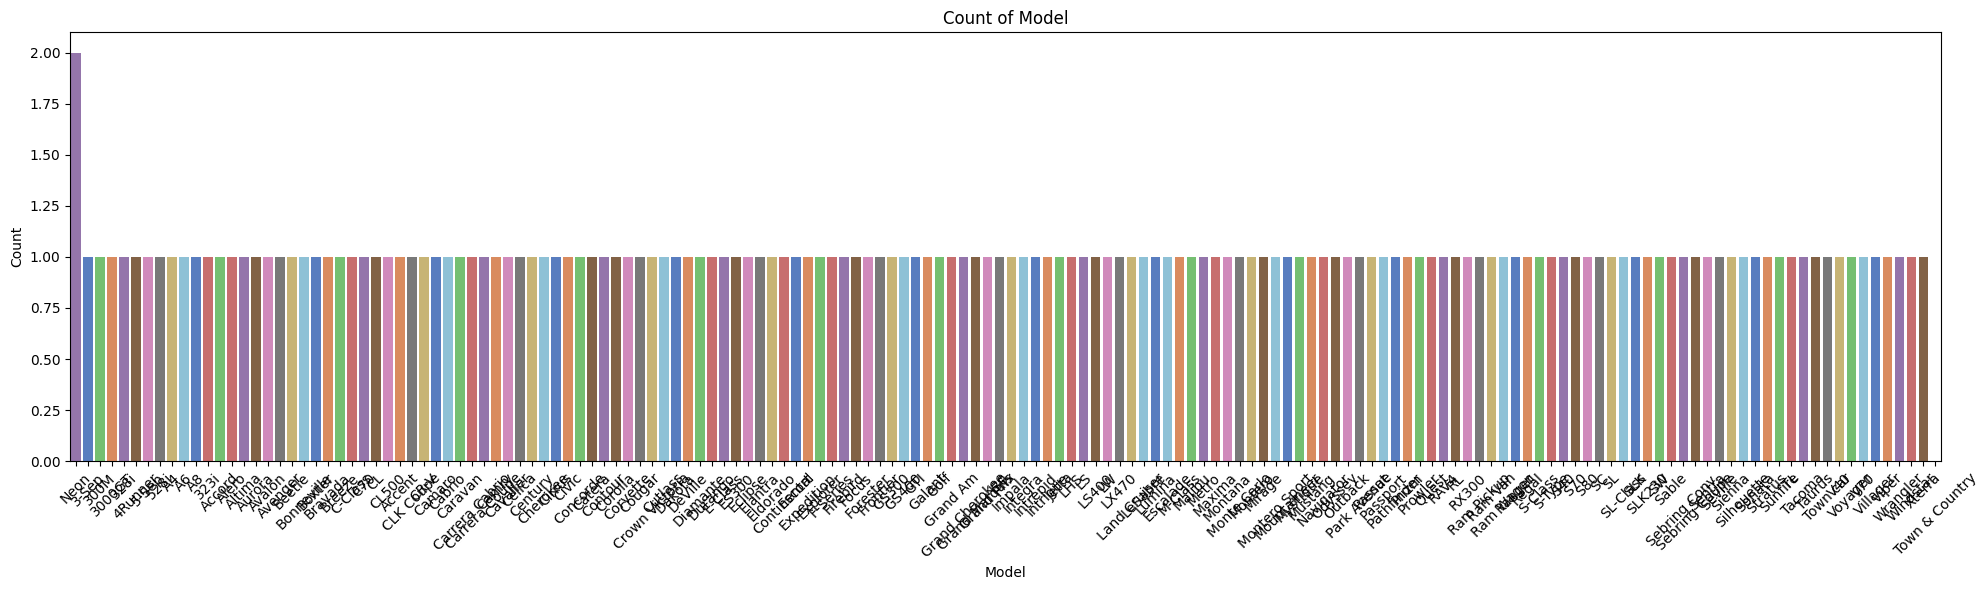


Column: Vehicle_type


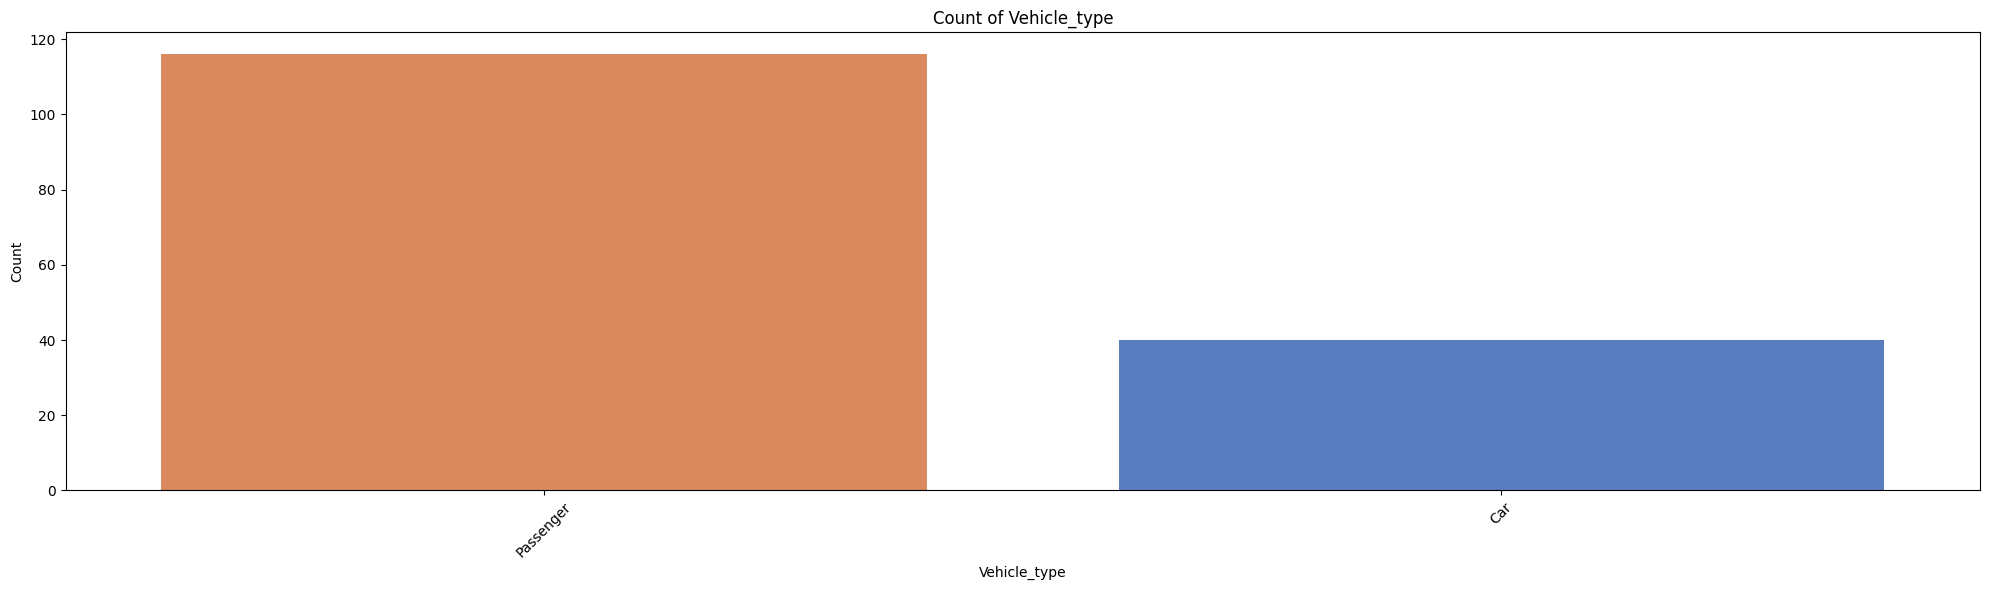

In [16]:
# Univariate Analysis - Categorical Feature
cat_cols = df.select_dtypes(include=['category']).columns

for col in cat_cols:
    print(f"\nColumn: {col}")

    plt.figure(figsize=(20,6))
    sns.countplot(
        data=df,
        x=col,
        order=df[col].value_counts().index,
        palette='muted',
        hue=col,      
        dodge=False 
    )
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Car Price Analysis (Categorical Features)

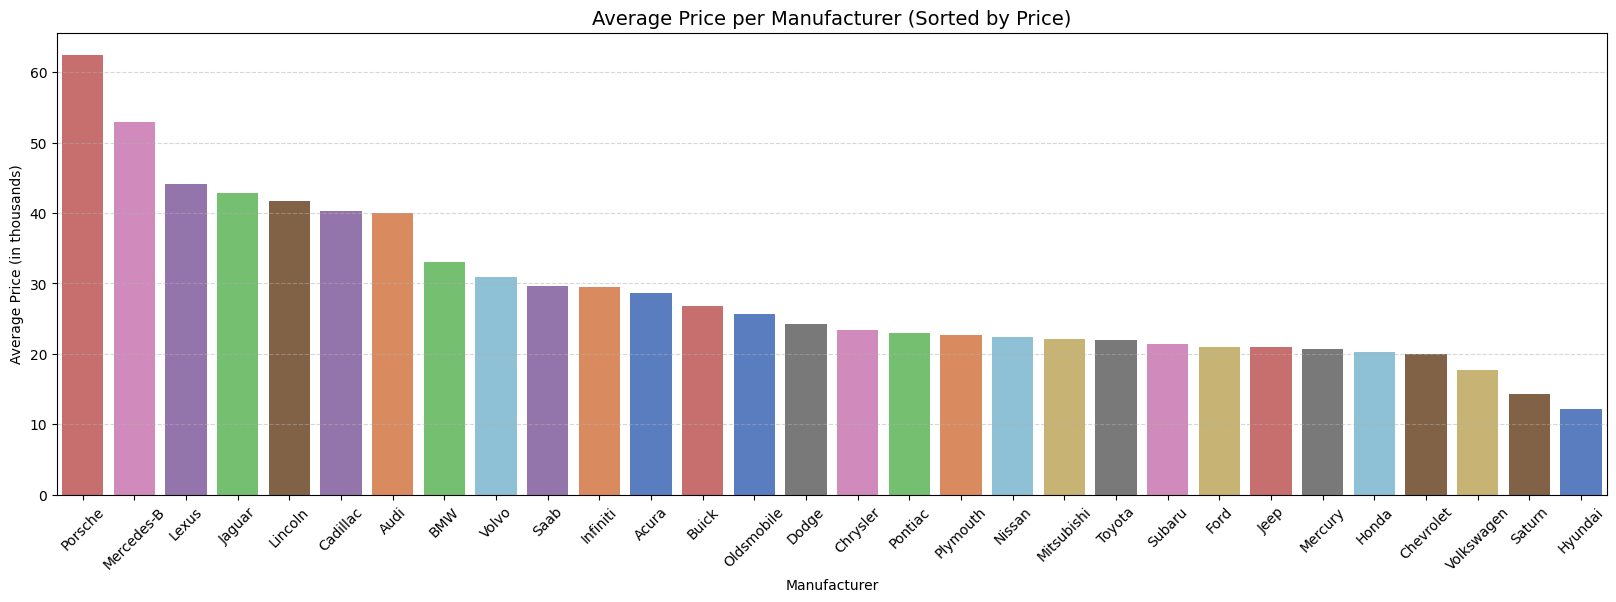

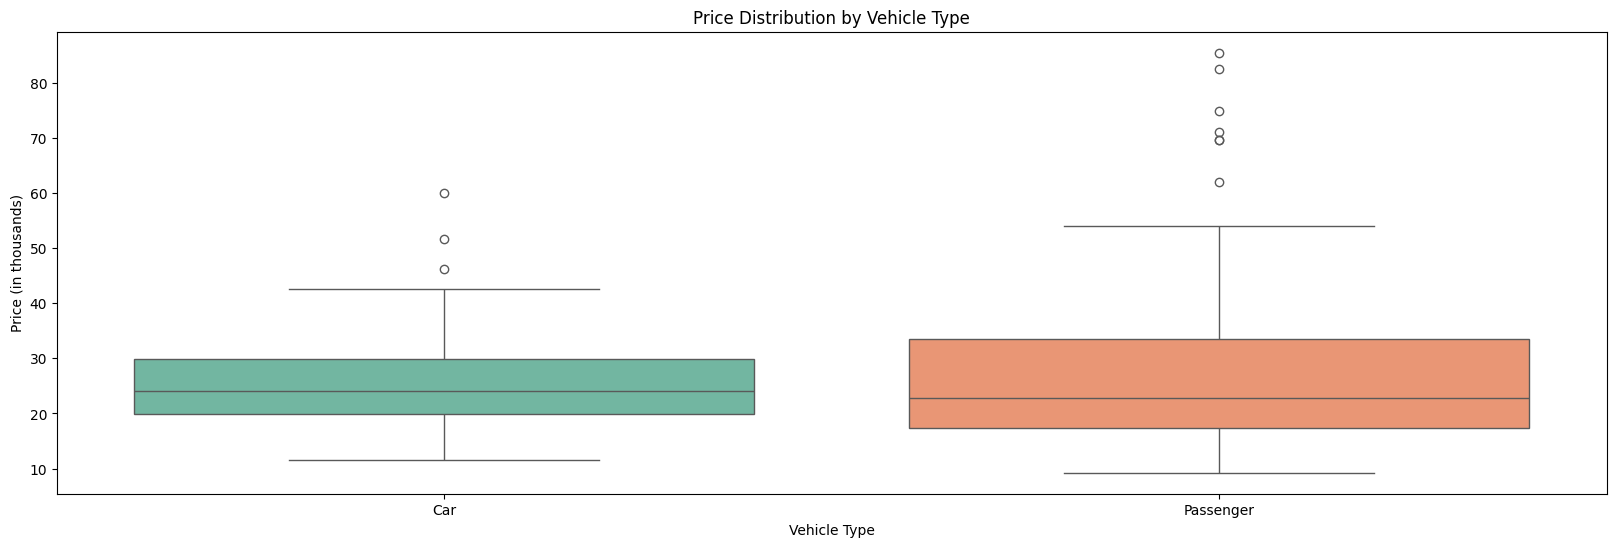

In [17]:
# Which manufacturer commands the highest average selling price?

# Aggregate and sort by average price
manufacturer_price_df = (df.groupby('Manufacturer', observed=True)['Price_in_thousands']
                         .mean().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_price_df['Manufacturer']

plt.figure(figsize=(20,6))
sns.barplot(data=manufacturer_price_df, 
            x="Manufacturer", 
            y="Price_in_thousands",
            order=manufacturer_order_list,  
            hue="Manufacturer", 
            legend=False, 
            palette='muted'
);

plt.xticks(rotation=45)
plt.title("Average Price per Manufacturer (Sorted by Price)", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Average Price (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Which vehicle type tend to be more expensive or have wider price variability?
plt.figure(figsize=(20,6))
sns.boxplot(data=df, x="Vehicle_type", y="Price_in_thousands", hue="Vehicle_type", palette='Set2');
plt.title("Price Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Price (in thousands)")
plt.show()

<Figure size 2000x600 with 0 Axes>

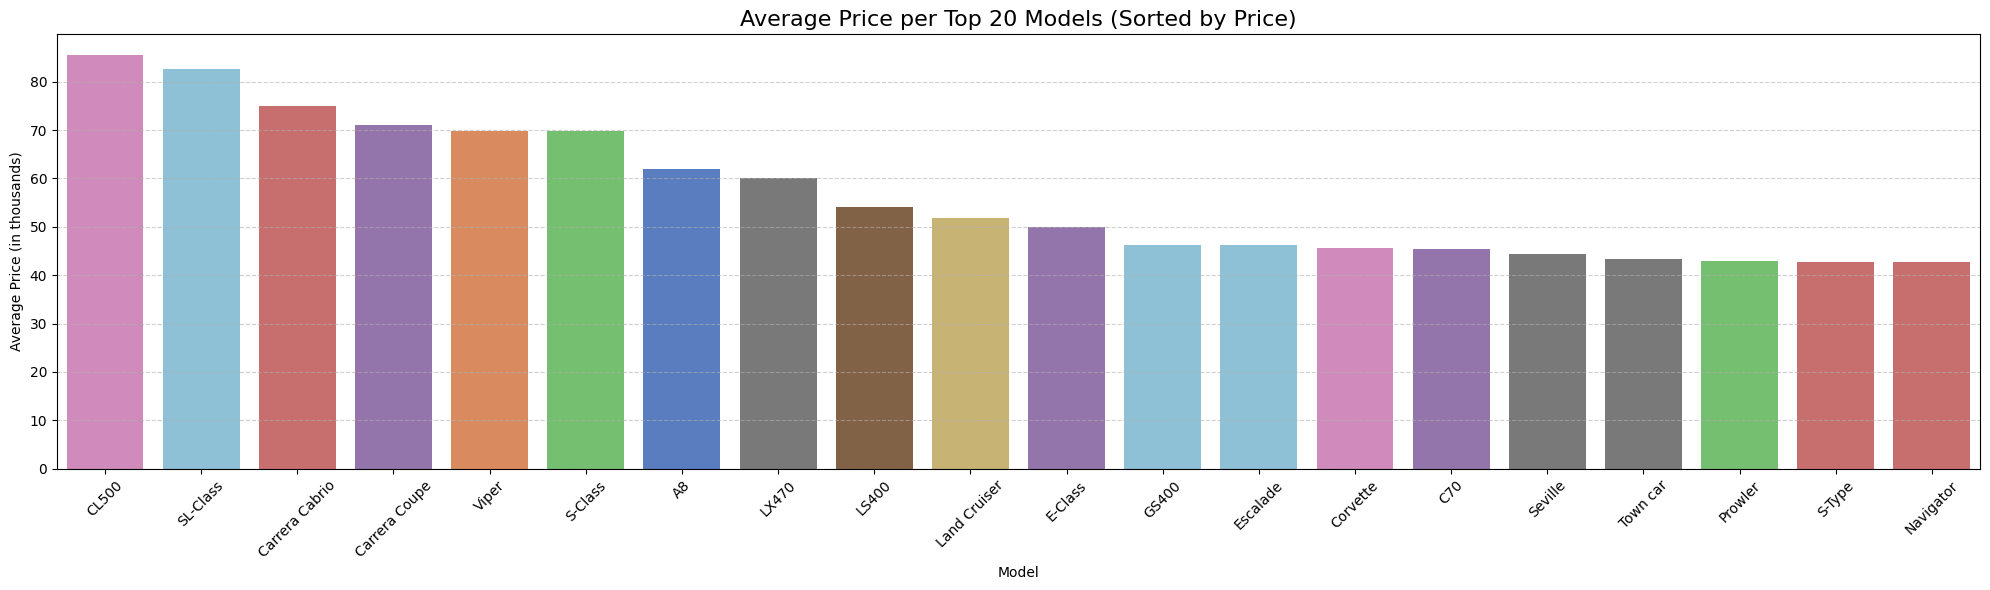

In [18]:
# Which TOP N model commands the highest average selling price?

TOP_N_MODELS = 20
plt.figure(figsize=(20,6))

# Aggregate and sort by average price
model_price_df = (df.groupby('Model', observed=True)['Price_in_thousands']
                         .mean().sort_values(ascending=False).reset_index())

# Select top N models
top_models_df = model_price_df.head(TOP_N_MODELS)
model_order_list = top_models_df['Model']

plt.figure(figsize=(20,6))
sns.barplot(
    data=top_models_df,
    x="Model",
    y="Price_in_thousands",
    hue="Model",
    order=model_order_list,  # ensures bars are sorted
    palette='muted',
    dodge=False
)

plt.xticks(rotation=45)
plt.title(f"Average Price per Top {TOP_N_MODELS} Models (Sorted by Price)", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Average Price (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

-- Selected price-driving features: ['Year_resale_value', 'Engine_size', 'Horsepower', 'Power_perf_factor']


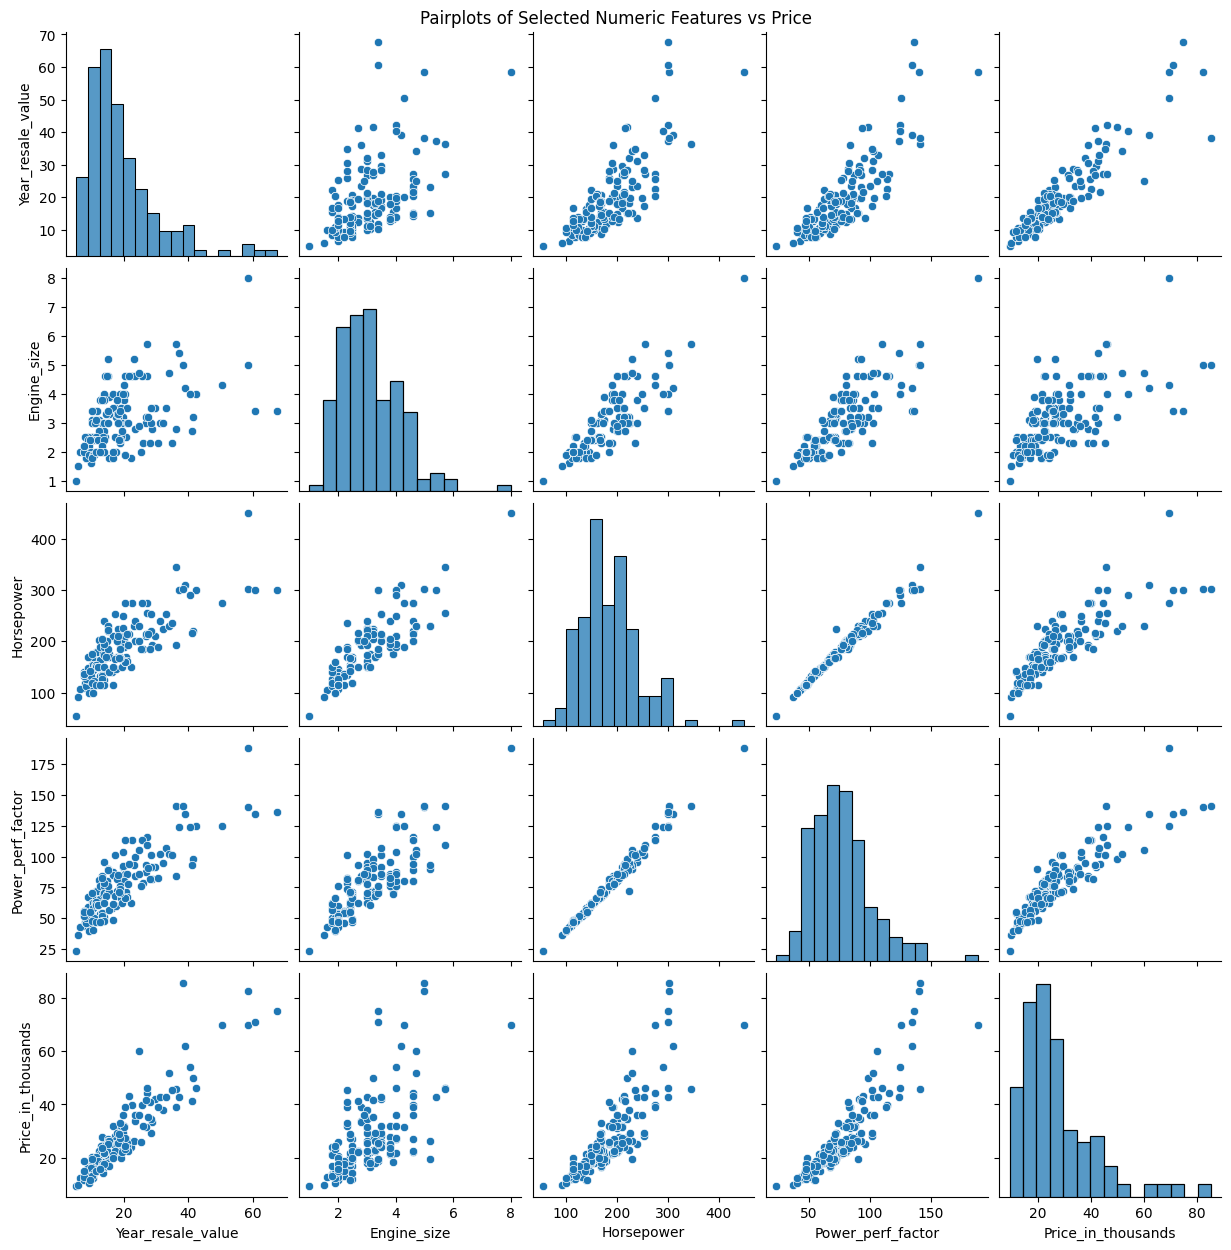

In [19]:
# Which car features most strongly influence price?
# how do performance or design attributes relate to pricing?

numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr().round(1)         # Correlation matrix

# Extract correlations with Price
resale_corr = corr_matrix["Price_in_thousands"].drop("Price_in_thousands")

# Select features with |correlation| >= 0.6
selected_price_features = resale_corr[resale_corr.abs() >= 0.6].index.tolist()
print("-- Selected price-driving features:", selected_price_features)

# Pairplot of selected features + Price
sns.pairplot(df[selected_price_features + ["Price_in_thousands"]])
plt.suptitle("Pairplots of Selected Numeric Features vs Price", y=1)
plt.show()

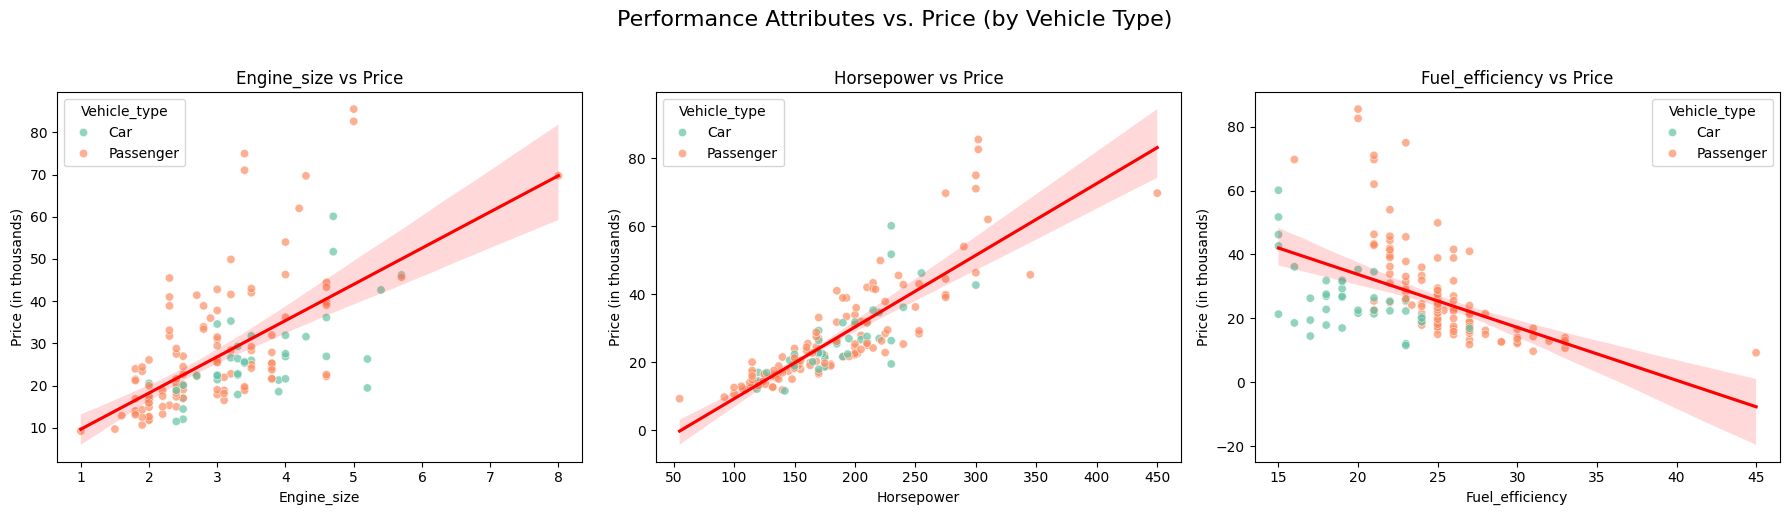

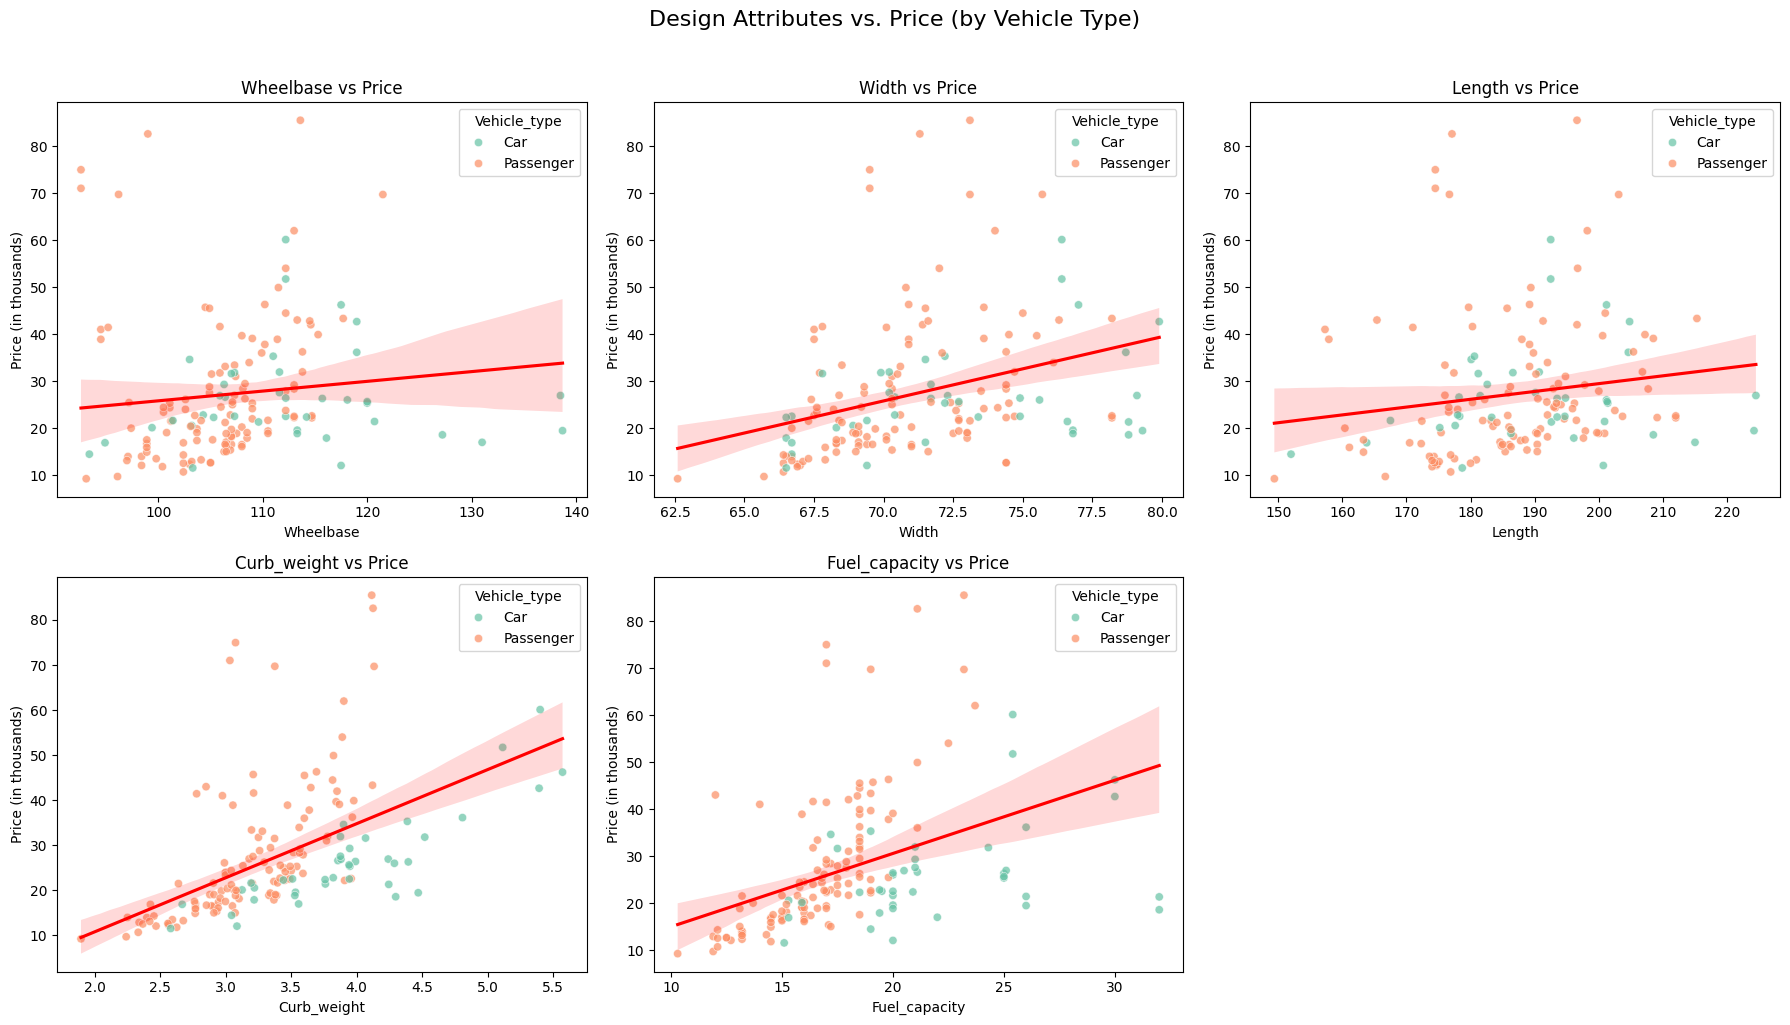

In [20]:
# How do performance attributes and design attributes influence car pricing?
# Do more powerful cars command higher prices?

performance = ['Engine_size', 'Horsepower', 'Fuel_efficiency']
design = ['Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity']

# Check if Vehicle_type column exists for hue
hue_col = 'Vehicle_type' if 'Vehicle_type' in df.columns else None

# Performance Attributes vs Price
n_perf = len(performance)
n_cols = 3
n_rows = (n_perf + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

idx = 0
for feature in performance:
    sns.scatterplot(
        data=df,
        x=feature,
        y='Price_in_thousands',
        hue=hue_col,
        alpha=0.7,
        palette='Set2',
        ax=axes[idx]
    )
    sns.regplot(
        data=df,
        x=feature,
        y='Price_in_thousands',
        scatter=False,
        color='red',
        ax=axes[idx]
    )
    axes[idx].set_title(f"{feature} vs Price", fontsize=12)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Price (in thousands)")
    idx += 1

# Remove unused subplots
while idx < len(axes):
    fig.delaxes(axes[idx])
    idx += 1

plt.suptitle("Performance Attributes vs. Price (by Vehicle Type)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Design Attributes vs Price
n_design = len(design)
n_cols = 3
n_rows = (n_design + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

idx = 0
for feature in design:
    sns.scatterplot(
        data=df,
        x=feature,
        y='Price_in_thousands',
        hue=hue_col,
        alpha=0.7,
        palette='Set2',
        ax=axes[idx]
    )
    sns.regplot(
        data=df,
        x=feature,
        y='Price_in_thousands',
        scatter=False,
        color='red',
        ax=axes[idx]
    )
    axes[idx].set_title(f"{feature} vs Price", fontsize=12)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Price (in thousands)")
    idx += 1

# Remove unused subplots
while idx < len(axes):
    fig.delaxes(axes[idx])
    idx += 1

plt.suptitle("Design Attributes vs. Price (by Vehicle Type)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



# Car Sales Analysis (Categorical Features)

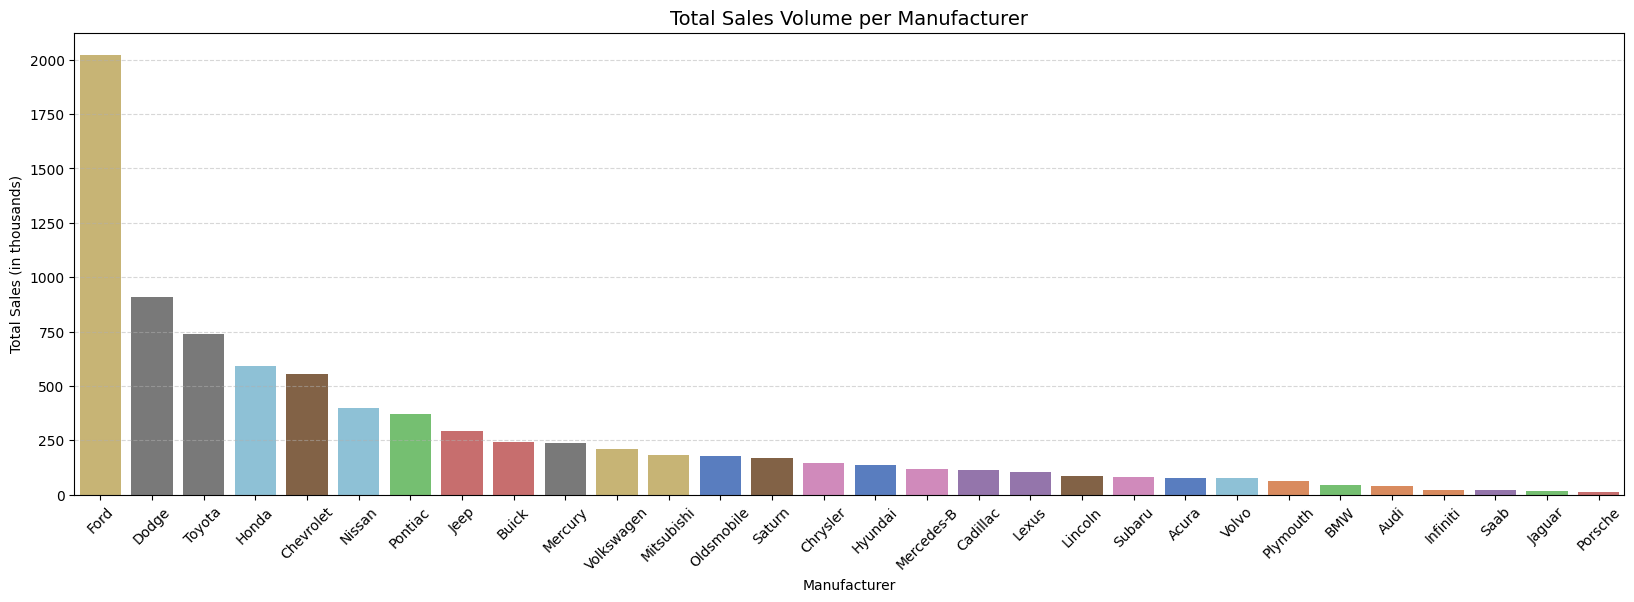

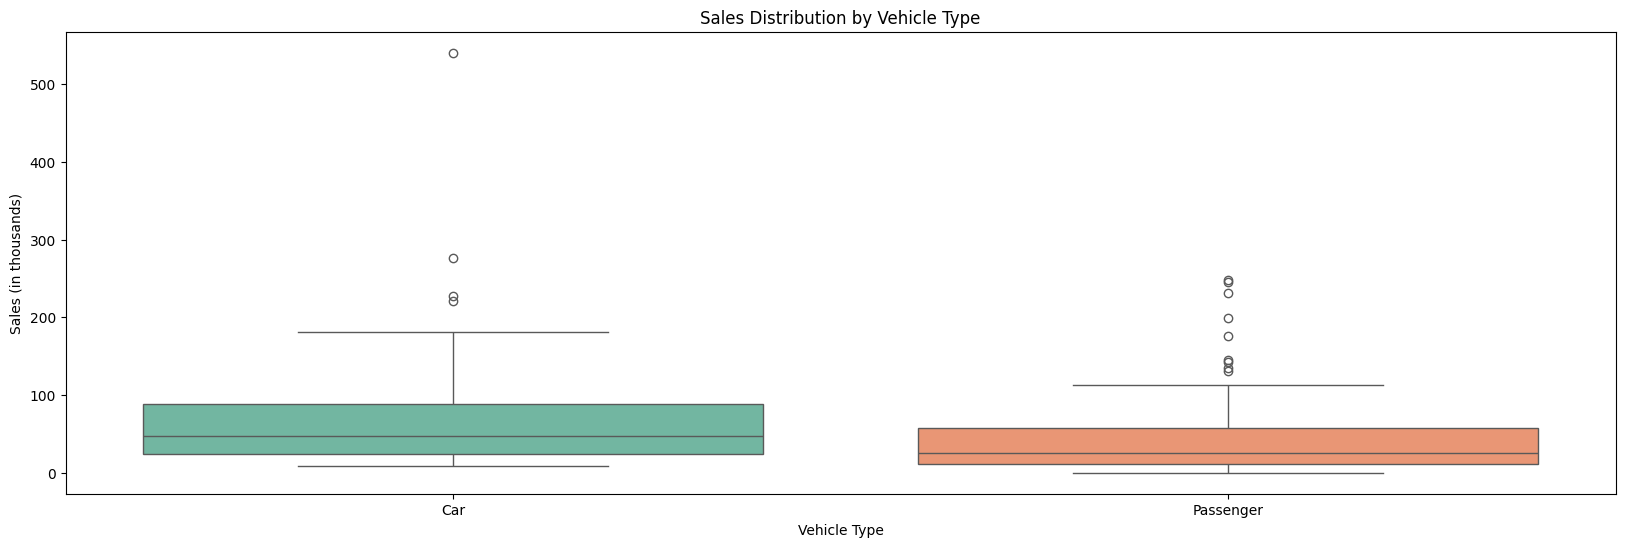

In [21]:
# Which car manufacturers dominate the sales volume?

plt.figure(figsize=(20,6))
manufacturer_sales_df = (df.groupby('Manufacturer', observed=True)['Sales_in_thousands'].sum().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_sales_df['Manufacturer']

# Plotting the PRE-SORTED DataFrame with explicit order
sns.barplot(
    data=manufacturer_sales_df,
    x="Manufacturer",
    y="Sales_in_thousands",
    order=manufacturer_order_list, 
    hue="Manufacturer", 
    legend=False,
    palette='muted' 
)

plt.xticks(rotation=45)
plt.title("Total Sales Volume per Manufacturer", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Total Sales (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Which types of vehicles sell the most?
plt.figure(figsize=(20,6))
sns.boxplot(data=df, x="Vehicle_type", y="Sales_in_thousands", hue="Vehicle_type", palette='Set2')
plt.title("Sales Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Sales (in thousands)")
plt.show()

<Figure size 2000x600 with 0 Axes>

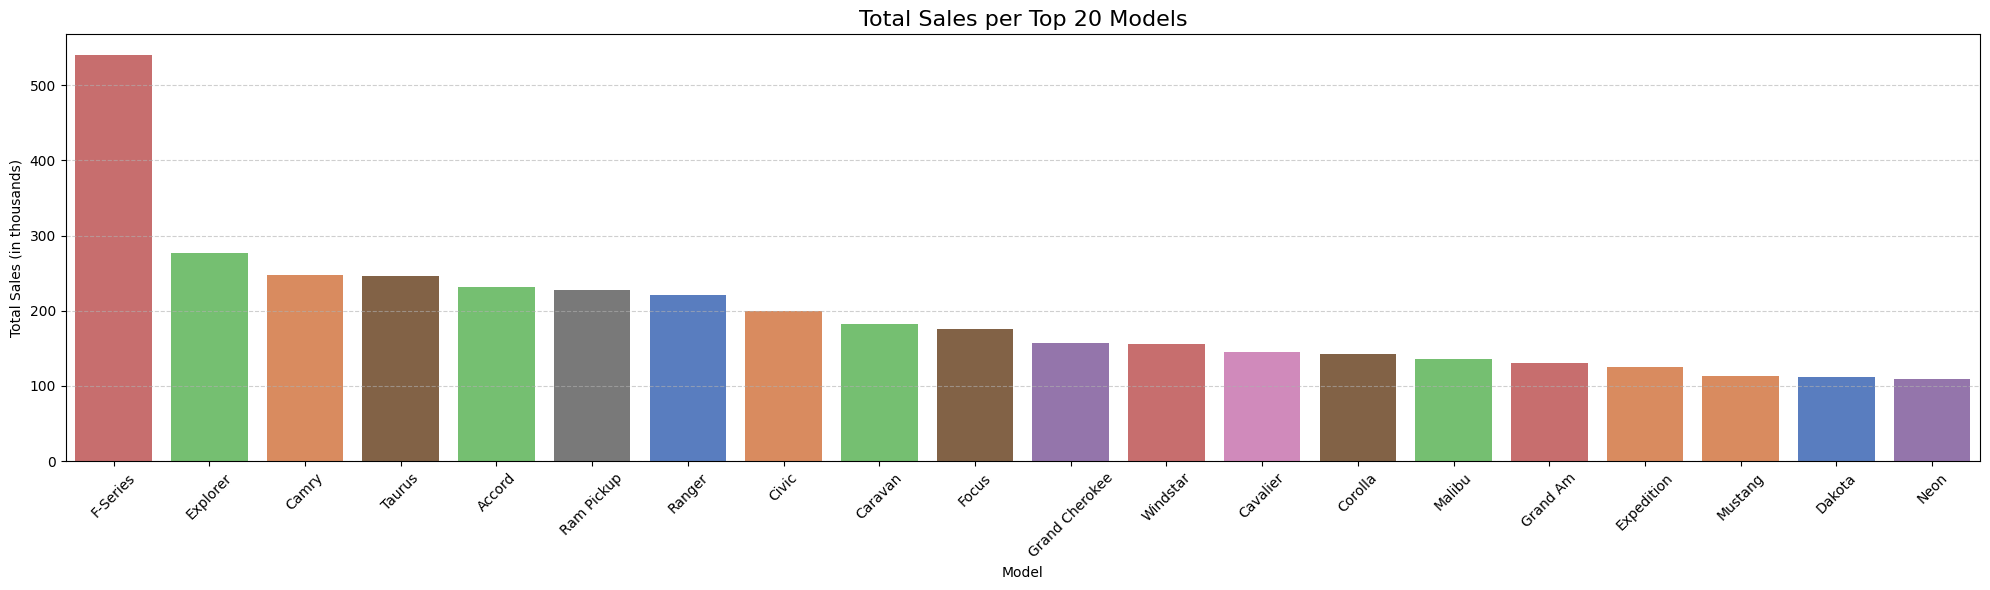

In [22]:
# Which TOP N model commands the highest sales?

TOP_N_MODELS = 20
plt.figure(figsize=(20,6))

# Aggregate and sort by average price
model_sales_df = (df.groupby('Model', observed=True)['Sales_in_thousands']
                         .sum().sort_values(ascending=False).reset_index())

# Select top N models
top_models_df = model_sales_df.head(TOP_N_MODELS)
model_order_list = top_models_df['Model']

plt.figure(figsize=(20,6))
sns.barplot(
    data=top_models_df,
    x="Model",
    y="Sales_in_thousands",
    hue="Model",
    order=model_order_list,
    palette='muted',
    dodge=False
)

plt.xticks(rotation=45)
plt.title(f"Total Sales per Top {TOP_N_MODELS} Models", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Total Sales (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

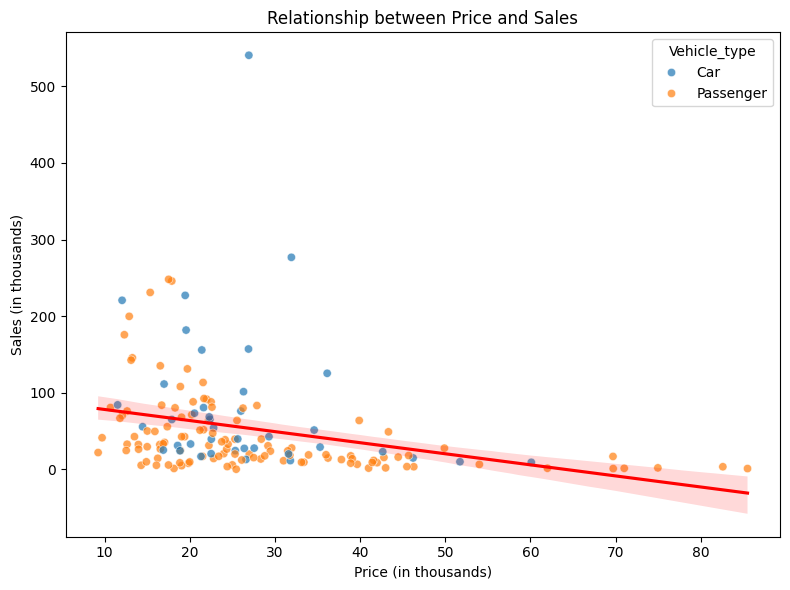

In [23]:
# How does car price influence sales volume?
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Price_in_thousands', y='Sales_in_thousands', hue='Vehicle_type',alpha=0.7)
sns.regplot(data=df, x='Price_in_thousands', y='Sales_in_thousands', scatter=False, color='red')
plt.title("Relationship between Price and Sales")
plt.xlabel("Price (in thousands)")
plt.ylabel("Sales (in thousands)")
plt.tight_layout()
plt.show()

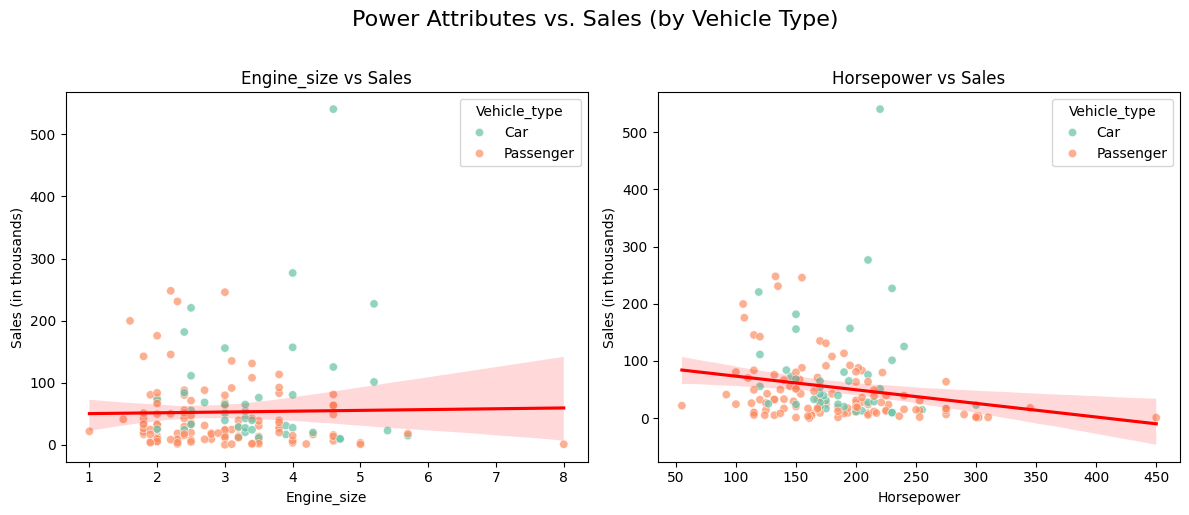

In [24]:
# Do cars with bigger engines or higher horsepower sell better?
power = ['Engine_size', 'Horsepower']
hue_col = 'Vehicle_type' if 'Vehicle_type' in df.columns else None

n_power = len(power)
n_cols = 2
n_rows = (n_power + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

idx = 0
for feature in power:
    sns.scatterplot(
        data=df,
        x=feature,
        y='Sales_in_thousands',
        hue=hue_col, 
        alpha=0.7,
        palette='Set2',
        ax=axes[idx]
    )

    sns.regplot(
        data=df,
        x=feature,
        y='Sales_in_thousands',
        scatter=False,
        color='red',
        ax=axes[idx]
    )

    axes[idx].set_title(f"{feature} vs Sales", fontsize=12)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Sales (in thousands)")
    idx += 1

# Remove unused subplots
while idx < len(axes):
    fig.delaxes(axes[idx])
    idx += 1

plt.suptitle("Power Attributes vs. Sales (by Vehicle Type)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Resales Analysis (Categorical Features)

In [25]:
# Compute Depreciation & Retention
df['Retention_Ratio'] = (df['Year_resale_value'] / df['Price_in_thousands']) * 100
df['Depreciation_Percentage'] = ((df['Price_in_thousands'] - df['Year_resale_value']) / df['Price_in_thousands']) * 100

avg_dep = df['Depreciation_Percentage'].mean()
avg_ret = df['Retention_Ratio'].mean()
print(f"Average Depreciation: {avg_dep:.1f}%")
print(f"Average Retention: {avg_ret:.1f}%\n")

# Average by vehicle type
type_summary = (
    df.groupby('Vehicle_type', observed=True)[['Depreciation_Percentage', 'Retention_Ratio']]
      .mean()
      .round(1)
)
print(type_summary)

Average Depreciation: 30.5%
Average Retention: 69.5%

              Depreciation_Percentage  Retention_Ratio
Vehicle_type                                          
Car                              28.8             71.2
Passenger                        31.0             69.0


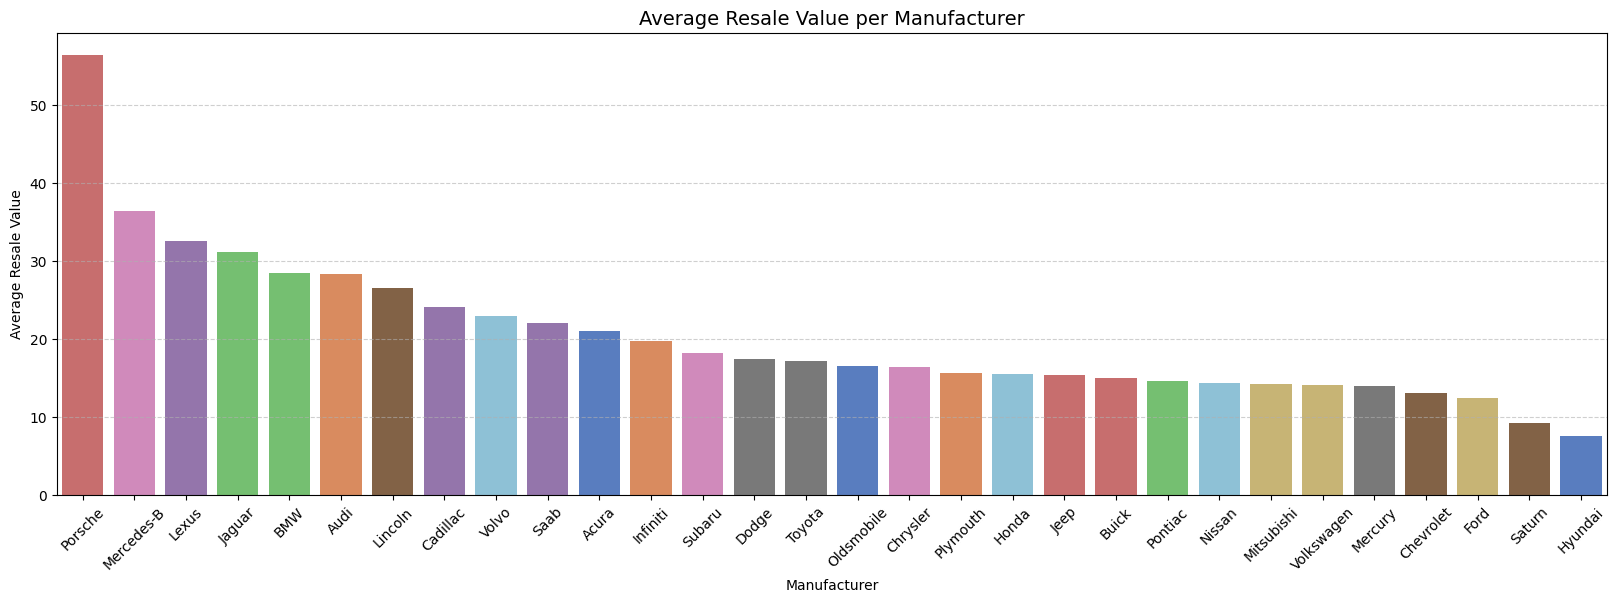

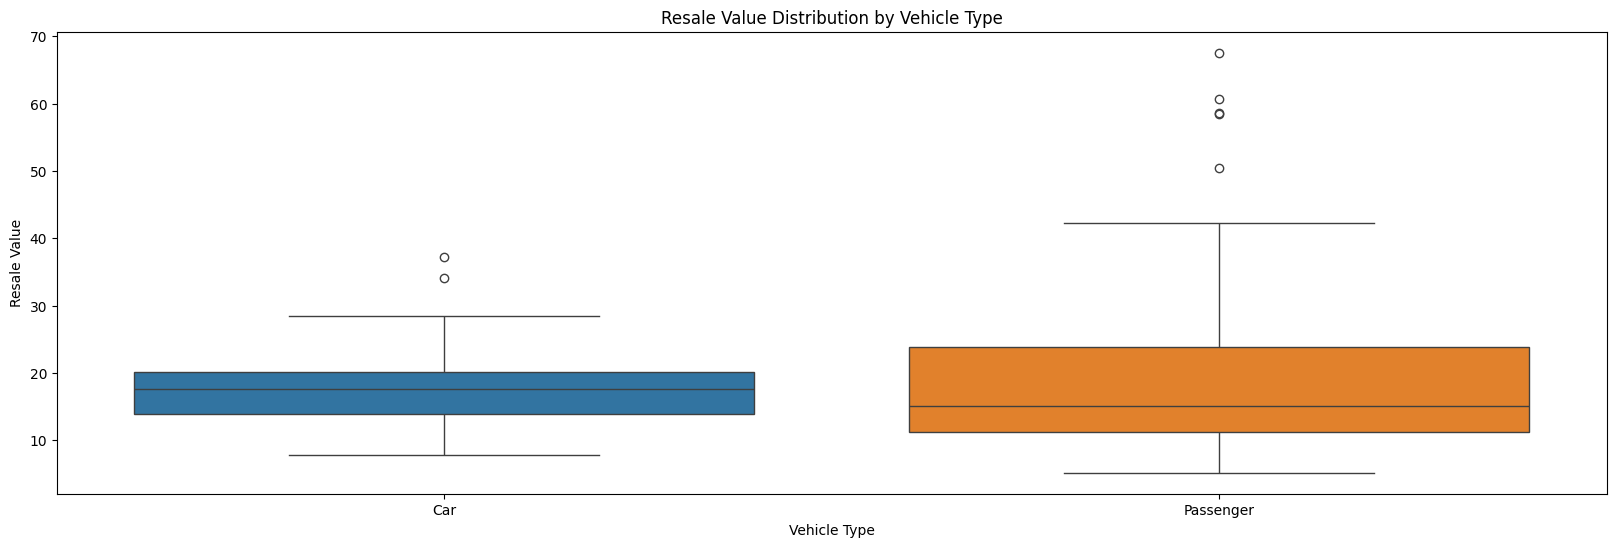

In [26]:
# Which manufacturers dominate the used car market in terms of resale performance?
plt.figure(figsize=(20,6))
manufacturer_resale_df = (df.groupby('Manufacturer', observed=True)['Year_resale_value']
                          .mean()
                          .sort_values(ascending=False).
                          reset_index()
                          )

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_resale_df['Manufacturer']
sns.barplot(
    data=manufacturer_resale_df,
    x="Manufacturer",
    y="Year_resale_value",
    order=manufacturer_order_list,
    hue="Manufacturer", 
    legend=False,
    palette='muted' 
)

plt.xticks(rotation=45)
plt.title("Average Resale Value per Manufacturer", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Average Resale Value")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#  Does vehicle type (Passenger vs Car) affect depreciation?
plt.figure(figsize=(20,6))
sns.boxplot(data=df, x="Vehicle_type", y="Year_resale_value", hue="Vehicle_type")
plt.title("Resale Value Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Resale Value")
plt.show()

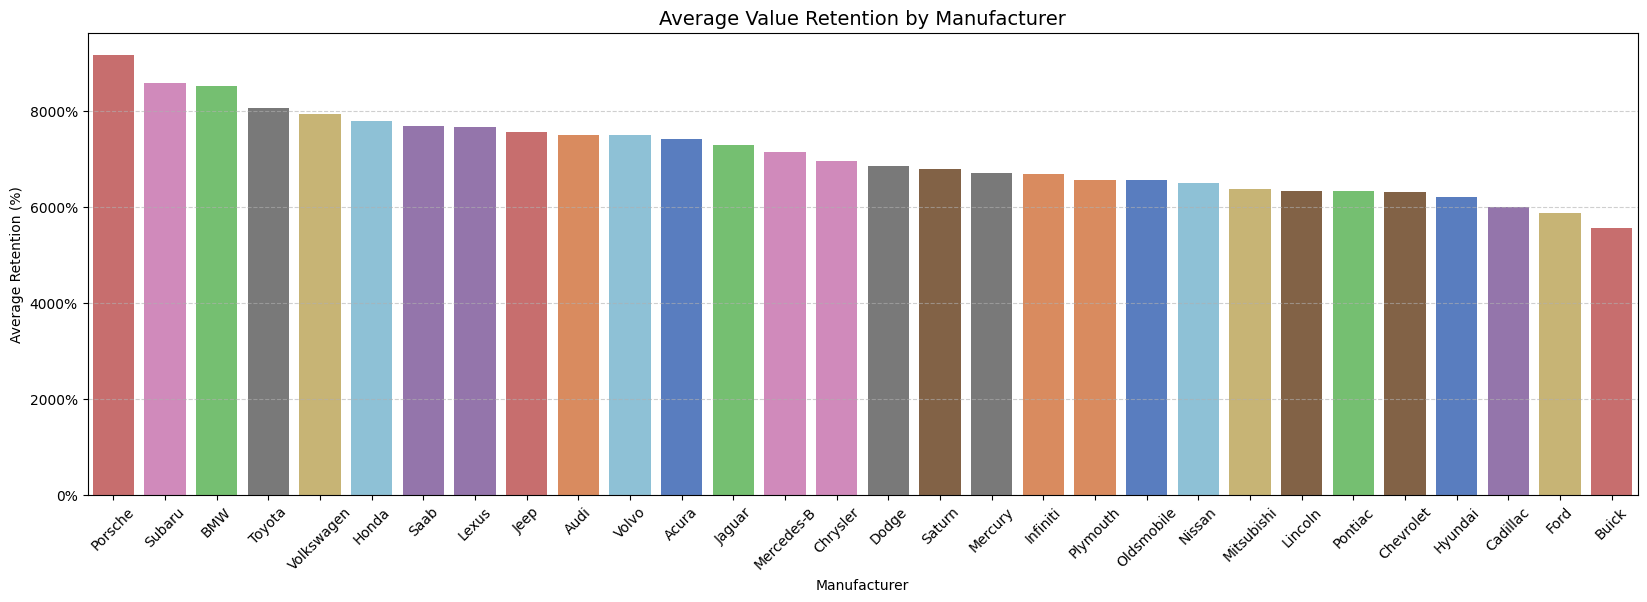

In [27]:
# Which brands provide the best value retention for buyers?

if all(col in df.columns for col in ['Manufacturer', 'Price_in_thousands', 'Year_resale_value']):
    
    # Group by manufacturer and calculate average retention ratio
    retention_df = (df.groupby('Manufacturer', observed=True)['Retention_Ratio']
                      .mean()
                      .sort_values(ascending=False)
                      .reset_index())
    
    # Extract sorted manufacturer order
    manu_order = retention_df['Manufacturer']
    
    # Plot results (sorted by Retention_Ratio)
    plt.figure(figsize=(20,6))
    sns.barplot(
        data=retention_df,
        x='Manufacturer',
        y='Retention_Ratio',
        hue='Manufacturer',     
        order=manu_order,     
        legend=False,
        palette='muted'
    )
    plt.xticks(rotation=45)
    plt.title("Average Value Retention by Manufacturer", fontsize=14)
    plt.xlabel("Manufacturer")
    plt.ylabel("Average Retention (%)")
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

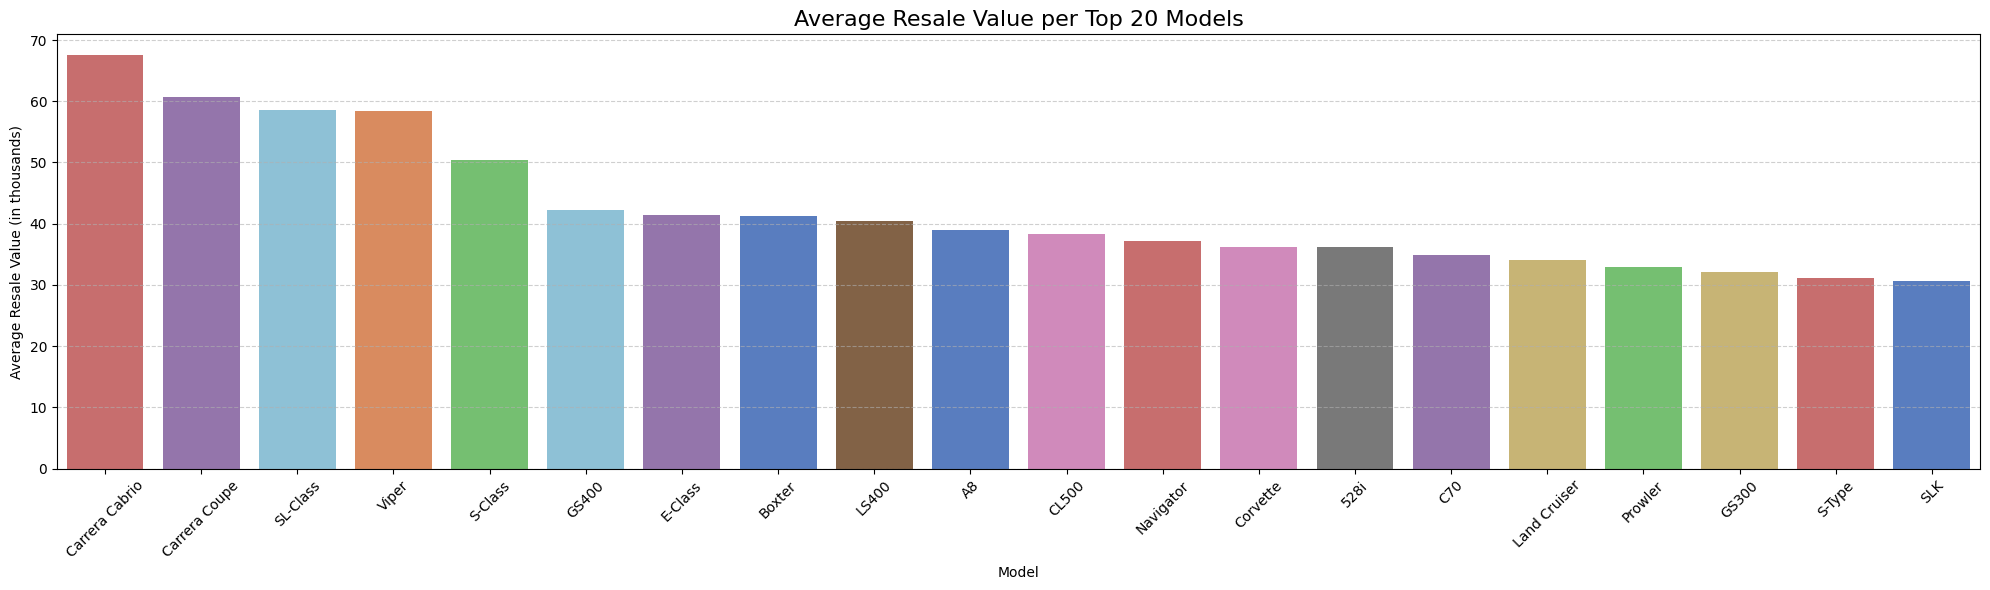

In [28]:
# Which TOP N model commands the highest resale values?

TOP_N_MODELS = 20

# Aggregate and sort by average price
model_resale_df = (df.groupby('Model', observed=True)['Year_resale_value']
                         .mean().sort_values(ascending=False).reset_index())

# Select top N models
top_models_df = model_resale_df.head(TOP_N_MODELS)
model_order_list = top_models_df['Model']

plt.figure(figsize=(20,6))
sns.barplot(
    data=top_models_df,
    x="Model",
    y="Year_resale_value",
    hue="Model",
    order=model_order_list,
    palette='muted',
    dodge=False
)

plt.xticks(rotation=45)
plt.title(f"Average Resale Value per Top {TOP_N_MODELS} Models", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Average Resale Value (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Selected resale-driving features: ['Price_in_thousands', 'Horsepower', 'Power_perf_factor']


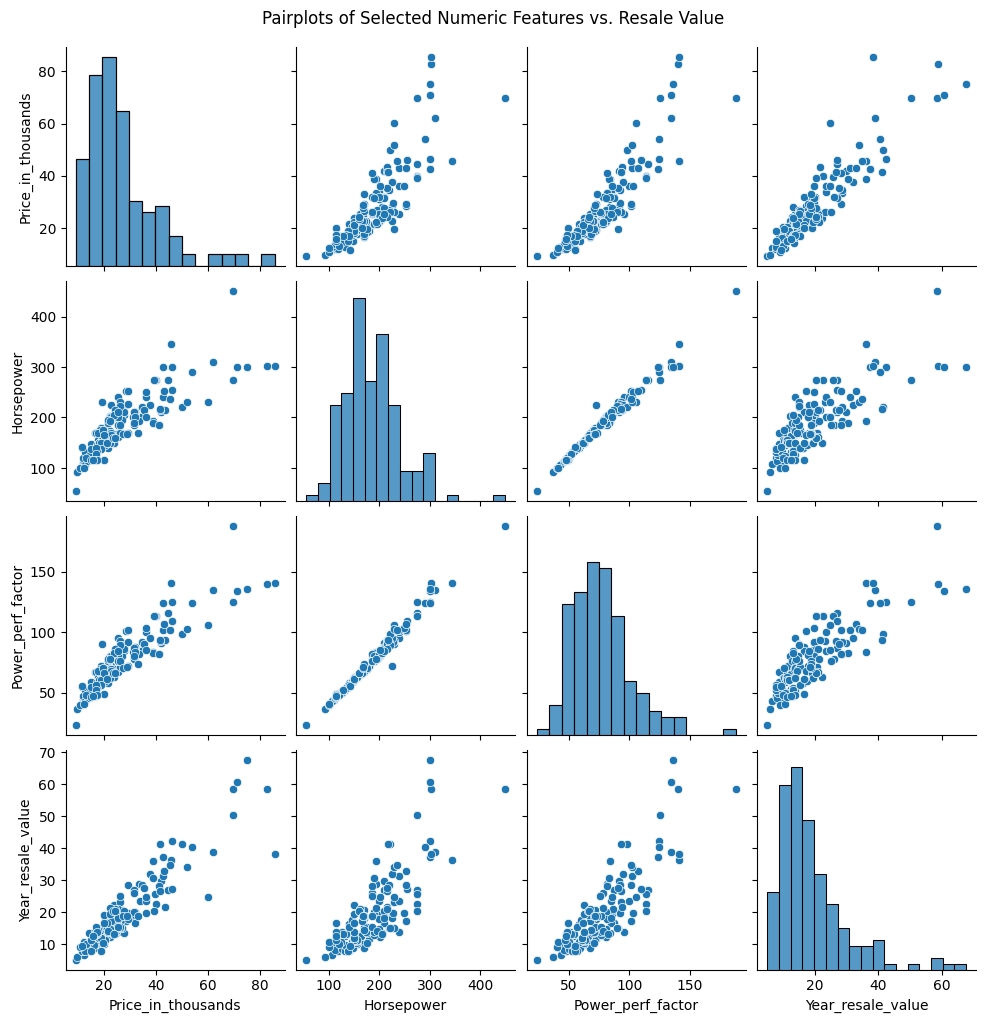

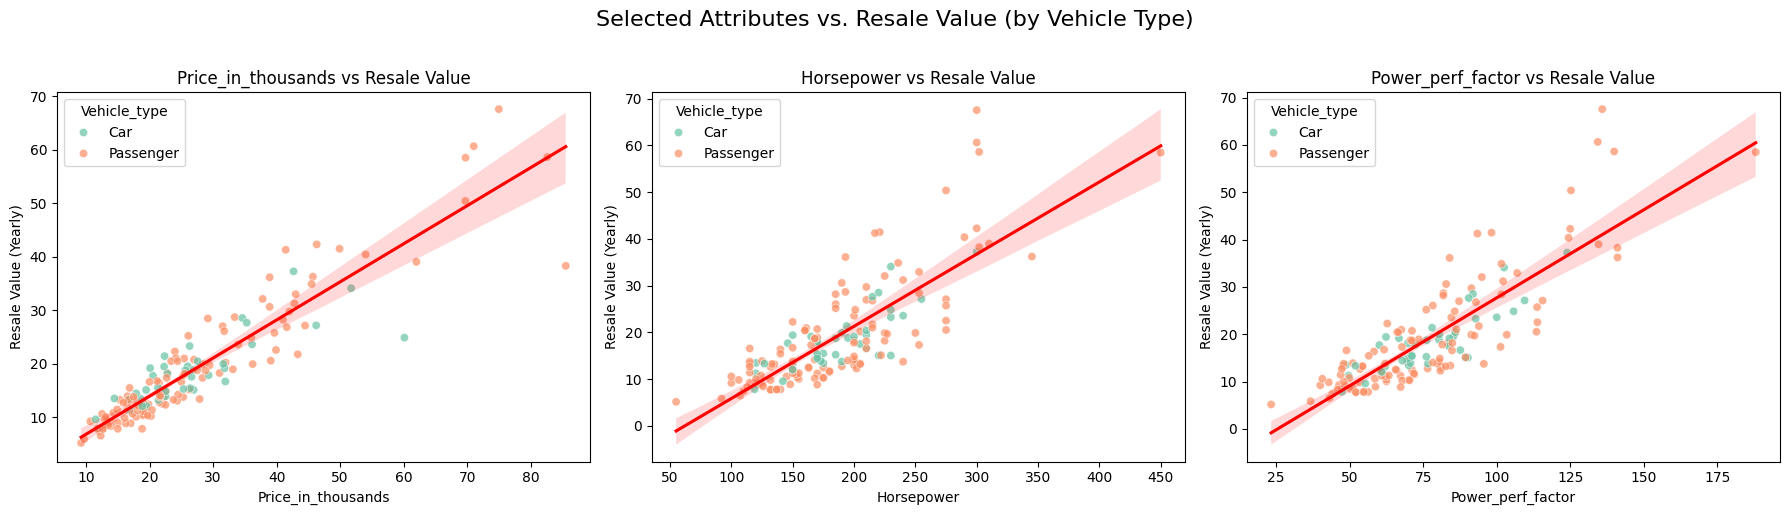

In [29]:
# Which factors influence car resale value?
# Does a higher original price guarantee a higher resale value?

resale_corr = corr_matrix["Year_resale_value"].drop("Year_resale_value")

# Select features with strong correlations (|corr| ≥ 0.6)
selected_resale_features = resale_corr[resale_corr.abs() >= 0.6].index.tolist()
print("Selected resale-driving features:", selected_resale_features)

# Pairplot of selected features + resale value
sns.pairplot(df[selected_resale_features + ["Year_resale_value"]])
plt.suptitle("Pairplots of Selected Numeric Features vs. Resale Value", y=1.02)
plt.show()

# Scatterplots — Selected features vs. Resale Value
hue_col = 'Vehicle_type' if 'Vehicle_type' in df.columns else None

n_features = len(selected_resale_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

idx = 0
for feature in selected_resale_features:
    sns.scatterplot(
        data=df,
        x=feature,
        y="Year_resale_value",
        hue=hue_col,
        alpha=0.7,
        palette="Set2",
        ax=axes[idx]
    )
    sns.regplot(
        data=df,
        x=feature,
        y="Year_resale_value",
        scatter=False,
        color="red",
        ax=axes[idx]
    )
    axes[idx].set_title(f"{feature} vs Resale Value", fontsize=12)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Resale Value (Yearly)")
    idx += 1

# Remove unused subplots
while idx < len(axes):
    fig.delaxes(axes[idx])
    idx += 1

plt.suptitle("Selected Attributes vs. Resale Value (by Vehicle Type)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Power-to-Performance Factor vs Key Business Metrics

# START HERE

In [ ]:
# How strongly does the Power-to-Performance Factor correlate 
# with key financial outcomes: vehicle price, sales volume, and resale value?

targets = ['Price_in_thousands', 'Sales_in_thousands', 'Year_resale_value']

for target in targets:
    if 'Power_perf_factor' in df.columns and target in df.columns:
        # Scatterplot with regression line
        plt.figure(figsize=(8,6))
        sns.scatterplot(data=df, x='Power_perf_factor', hue='Vehicle_type', y=target, alpha=0.7)
        sns.regplot(data=df, x='Power_perf_factor', y=target, scatter=False, color='red')
        plt.title(f"Power_perf_factor vs {target}")
        plt.xlabel("Power_perf_factor")
        plt.ylabel(target)
        plt.show()

# Design and Efficiency Trade-Off

In [ ]:
# How do a car’s price and fuel efficiency relate, and does this relationship differ by manufacturer?

# Ensure required columns exist
required_cols = ['Price_in_thousands', 'Fuel_efficiency', 'Manufacturer']
if all(col in df.columns for col in required_cols):

    plt.figure(figsize=(12,7))
    
    # Scatter points colored by Manufacturer
    sns.scatterplot(
        data=df,
        x='Price_in_thousands',
        y='Fuel_efficiency',
        hue='Manufacturer',
        palette='tab20',
        alpha=0.7,
        s=80
    )
    
    # Add regression lines per Manufacturer
    manufacturers = df['Manufacturer'].unique()
    for manu in manufacturers:
        manu_data = df[df['Manufacturer'] == manu]
        sns.regplot(
            data=manu_data,
            x='Price_in_thousands',
            y='Fuel_efficiency',
            scatter=False,
            label=None,  # avoid extra legend entries
            line_kws={'linewidth':1, 'alpha':0.6}
        )
    
    plt.title("Price vs Fuel Efficiency by Manufacturer with Trend Lines")
    plt.xlabel("Price (in thousands)")
    plt.ylabel("Fuel Efficiency (mpg)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Manufacturer")
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
# Design and Efficiency Trade-Off
# How do a car’s price and fuel efficiency relate, and does this relationship differ by Vehicle Type?

# Ensure required columns exist
required_cols = ['Price_in_thousands', 'Fuel_efficiency', 'Vehicle_type']
if all(col in df.columns for col in required_cols):

    plt.figure(figsize=(10,6))
    
    # Scatter points colored by Vehicle Type
    sns.scatterplot(
        data=df,
        x='Price_in_thousands',
        y='Fuel_efficiency',
        hue='Vehicle_type',
        palette='Set2',
        alpha=0.7,
        s=80
    )
    
    # Add regression lines per Vehicle Type
    vehicle_types = df['Vehicle_type'].unique()
    for vtype in vehicle_types:
        vtype_data = df[df['Vehicle_type'] == vtype]
        sns.regplot(
            data=vtype_data,
            x='Price_in_thousands',
            y='Fuel_efficiency',
            scatter=False,
            label=None,  # avoid duplicate legend entries
            line_kws={'linewidth':2, 'alpha':0.6}
        )
    
    plt.title("Price vs Fuel Efficiency by Vehicle Type with Trend Lines")
    plt.xlabel("Price (in thousands)")
    plt.ylabel("Fuel Efficiency (mpg)")
    plt.legend(title="Vehicle Type")
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
# How do design factors (Wheelbase, Width, Length, Curb_weight) influence fuel efficiency?

# Correlation heatmap (optional summary)
corr_cols = ['Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_efficiency']
corr_matrix = df[corr_cols].corr()
    
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Between Design Factors and Fuel Efficiency")
plt.show()



In [ ]:
# How do design factors (Wheelbase, Width, Length, Curb_weight) influence fuel efficiency?
#pairplot

# Select relevant columns
cols = ['Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_efficiency', 'Vehicle_type']

# Pairplot
sns.pairplot(
    df[cols],
    hue='Vehicle_type',
    palette='Set2',
    diag_kind='kde',        # Kernel density estimate for the diagonal
    plot_kws={'alpha':0.7}  # Transparency for points
)
plt.suptitle("Pairplot of Design Factors vs Fuel Efficiency by Vehicle Type", y=1.02)
plt.show()


In [ ]:
# What is the trade-off between Engine_size and Fuel_efficiency?

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='Engine_size',
    y='Fuel_efficiency',
    hue='Vehicle_type',   # Color by vehicle type
    palette='Set2',
    alpha=0.7
)

# Optional regression line for overall trend
sns.regplot(
    data=df,
    x='Engine_size',
    y='Fuel_efficiency',
    scatter=False,
    color='red',
    line_kws={'linewidth':2}
)

plt.title("Trade-off between Engine Size and Fuel Efficiency")
plt.xlabel("Engine Size (L)")
plt.ylabel("Fuel Efficiency (mpg)")
plt.show()


In [ ]:
# What is the distribution of vehicle types?

# Count of each vehicle type
vehicle_counts = df['Vehicle_type'].value_counts()

# Bar plot
plt.figure(figsize=(6,5))
sns.countplot(data=df, x='Vehicle_type', hue='Vehicle_type', palette='Set2')
plt.title("Distribution of Vehicle Types")
plt.xlabel("Vehicle Type")
plt.ylabel("Number of Models")
plt.show()


In [ ]:
# Can cars be clustered into natural groups (economy, family, performance, luxury)?

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features relevant for clustering
features = ['Price_in_thousands', 'Engine_size', 'Horsepower', 'Fuel_efficiency', 'Curb_weight']
X = df[features].copy()

# Handle missing values (if any)
X = X.fillna(X.mean())

# Standardize features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Inspect cluster centers
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print("Cluster Centers (approximate feature values):")
print(centers)

# Label clusters based on their characteristics
# We analyze the centers to assign meaningful names
cluster_labels = {}
for i, row in centers.iterrows():
    if row['Price_in_thousands'] <= 25 and row['Fuel_efficiency'] >= 25:
        cluster_labels[i] = 'Economy'
    elif row['Price_in_thousands'] <= 40 and row['Curb_weight'] >= 3.3:
        cluster_labels[i] = 'Family'
    elif row['Horsepower'] >= 250:
        cluster_labels[i] = 'Performance'
    else:
        cluster_labels[i] = 'Luxury'

# Map numeric clusters to descriptive labels
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

# Count of models per cluster
print(df['Cluster_Label'].value_counts())

# Visualize clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df, 
    x='Price_in_thousands', 
    y='Fuel_efficiency', 
    hue='Cluster_Label',
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title("Car Clusters Based on Features")
plt.xlabel("Price (in thousands)")
plt.ylabel("Fuel Efficiency (mpg)")
plt.legend(title="Cluster")
plt.show()

"""
Explanation of the clusters (based on features):

Economy

Low price, high fuel efficiency, moderate engine size and horsepower.

Example: Small city cars or compact sedans.

Family

Moderate price, higher curb weight, decent fuel efficiency.

Example: SUVs, minivans, or family sedans.

Performance

High horsepower, larger engines, lower fuel efficiency.

Example: Sports cars, performance sedans.

Luxury

High price, moderate fuel efficiency, premium features (not necessarily extreme horsepower).

Example: Luxury sedans, SUVs with comfort-focused features.
"""

In [ ]:
# Are there clusters of top-selling models by price and feature set?
# 5. Clusters / Top-Selling Models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant features for clustering
X = df[["Price_in_thousands","Sales_in_thousands","Horsepower","Engine_size"]].dropna()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="Price_in_thousands",
    y="Sales_in_thousands",
    hue="Cluster",
    size="Horsepower",
    data=df,
    palette="tab10",
    alpha=0.7,
    sizes=(50, 400)
)
plt.title("Clusters of Cars by Price, Features & Sales")
plt.show()

# Show top models in each cluster
top_models = df.groupby("Cluster").apply(lambda g: g.nlargest(3, "Sales_in_thousands")[["Manufacturer","Price_in_thousands","Sales_in_thousands"]])
print(top_models)



In [ ]:
# Number of Models
# Total number of unique models in the dataset
total_models = df['Model'].nunique()
print(f"Total unique car models: {total_models}")

# Number of models per manufacturer
models_per_manufacturer = df.groupby('Manufacturer')['Model'].nunique().sort_values(ascending=False)
print(models_per_manufacturer)



In [ ]:
# Are clusters linked to specific Make, Vehicle_Type?

# Assume df already has a 'Cluster' column from previous clustering step
# Example: df['Cluster'] = kmeans.labels_

# -----------------------------
# 1. Check cluster distribution by Manufacturer
cluster_make = pd.crosstab(df['Cluster'], df['Manufacturer'], normalize='index') * 100  # percentage
print("Percentage of each Manufacturer in each Cluster:")
print(cluster_make)

# Optional: heatmap visualization
plt.figure(figsize=(12,6))
sns.heatmap(cluster_make, annot=True, fmt=".1f", cmap="viridis")
plt.title("Cluster Distribution by Manufacturer (%)")
plt.xlabel("Manufacturer")
plt.ylabel("Cluster")
plt.show()

# -----------------------------
# 2. Check cluster distribution by Vehicle_Type
cluster_type = pd.crosstab(df['Cluster'], df['Vehicle_type'], normalize='index') * 100  # percentage
print("Percentage of each Vehicle_Type in each Cluster:")
print(cluster_type)

# Heatmap visualization
plt.figure(figsize=(8,5))
sns.heatmap(cluster_type, annot=True, fmt=".1f", cmap="magma")
plt.title("Cluster Distribution by Vehicle Type (%)")
plt.xlabel("Vehicle Type")
plt.ylabel("Cluster")
plt.show()



In [ ]:
# KMeans clustering
features = ['Price_in_thousands','Horsepower','Engine_size','Fuel_efficiency']
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = np.nan
df.loc[X.index, 'Cluster'] = clusters

# Cluster scatterplot: Horsepower vs Fuel Efficiency
sns.scatterplot(x='Horsepower', y='Fuel_efficiency', hue='Cluster', palette='tab10', data=df)
plt.title("Vehicle Clusters: Horsepower vs Fuel Efficiency")
plt.show()

# Cluster distribution by Vehicle_Type
pd.crosstab(df['Cluster'], df['Vehicle_type']).plot(kind='bar', stacked=True)
plt.title("Cluster Distribution by Vehicle_Type")
plt.show()



In [ ]:
# Analyze clusters vs Sales, Resale Value, and design characteristics

# Assume df already has a 'Cluster' column from previous clustering step
# Example: df['Cluster'] = kmeans.labels_

# 1. Average Sales per Cluster
avg_sales = df.groupby('Cluster')['Sales_in_thousands'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=avg_sales, x='Cluster', y='Sales_in_thousands', palette='viridis')
plt.title("Average Sales per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Sales (in thousands)")
plt.show()

# 2. Average 1-Year Resale Value per Cluster
avg_resale = df.groupby('Cluster')['Year_resale_value'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=avg_resale, x='Cluster', y='Year_resale_value', palette='magma')
plt.title("Average 1-Year Resale Value per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Resale Value (in thousands)")
plt.show()

# 3. Design Characteristics per Cluster
# Features like Wheelbase, Width, Length, Curb_weight
design_features = ['Wheelbase', 'Width', 'Length', 'Curb_weight']
design_avg = df.groupby('Cluster')[design_features].mean().reset_index()

# Plot as multiple barplots
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

for i, feature in enumerate(design_features):
    sns.barplot(data=design_avg, x='Cluster', y=feature, palette='coolwarm', ax=axes[i])
    axes[i].set_title(f"Average {feature} per Cluster")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

# 4. Optional: Pairplot to visualize cluster distribution over design features
sns.pairplot(df, vars=design_features, hue='Cluster', palette='Set2')
plt.suptitle("Design Characteristics vs Cluster", y=1.02)
plt.show()



In [ ]:
# Are newer cars more fuel-efficient?

# Ensure required columns exist
required_cols = ['Latest_Launch', 'Fuel_efficiency']  # Replace with actual column name
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime if not already
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'])

    # Calculate age in years relative to today
    today = pd.Timestamp.today()
    df['Age_years'] = (today - df['Latest_Launch']).dt.days / 365

    plt.figure(figsize=(10,6))
    
    # Scatter plot: Fuel Efficiency vs Age
    sns.scatterplot(
        data=df,
        x='Age_years',
        y='Fuel_efficiency',
        alpha=0.6
    )
    
    # Regression line to show trend
    sns.regplot(
        data=df,
        x='Age_years',
        y='Fuel_efficiency',
        scatter=False,
        color='red',
        line_kws={'linewidth':2}
    )
    
    plt.title("Fuel Efficiency vs Car Age")
    plt.xlabel("Car Age (years since latest launch)")
    plt.ylabel("Fuel Efficiency (MPG or L/100km)")
    plt.gca().invert_xaxis()  # Optional: show newer cars on left
    plt.show()
    
    # Optional: Average fuel efficiency by launch year
    df['Launch_Year'] = df['Latest_Launch'].dt.year
    avg_fuel = df.groupby('Launch_Year')['Fuel_efficiency'].mean()
    
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_fuel.index, y=avg_fuel.values, marker='o')
    plt.title("Average Fuel Efficiency by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Fuel Efficiency")
    plt.show()



In [ ]:
# Engine Size and Horsepower vs Year / Launch
# Are engine sizes or horsepower increasing over time?

required_cols = ['Latest_Launch', 'Engine_size', 'Horsepower']
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime if not already
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'])
    df['Launch_Year'] = df['Latest_Launch'].dt.year

    # 1. Engine Size over time
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x='Launch_Year', y='Engine_size', alpha=0.6)
    sns.regplot(data=df, x='Launch_Year', y='Engine_size', scatter=False, color='red', line_kws={'linewidth':2})
    plt.title("Engine Size vs Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Engine Size (Liters)")
    plt.show()

    # Optional: Average engine size by year
    avg_engine = df.groupby('Launch_Year')['Engine_size'].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_engine.index, y=avg_engine.values, marker='o')
    plt.title("Average Engine Size by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Engine Size (Liters)")
    plt.show()

    # 2. Horsepower over time
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x='Launch_Year', y='Horsepower', alpha=0.6)
    sns.regplot(data=df, x='Launch_Year', y='Horsepower', scatter=False, color='red', line_kws={'linewidth':2})
    plt.title("Horsepower vs Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Horsepower (HP)")
    plt.show()

    # Optional: Average horsepower by year
    avg_hp = df.groupby('Launch_Year')['Horsepower'].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_hp.index, y=avg_hp.values, marker='o')
    plt.title("Average Horsepower by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Horsepower (HP)")
    plt.show()




In [ ]:
# Are newer cars more expensive?

required_cols = ['Latest_Launch', 'Price_in_thousands']
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime if not already
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'])
    df['Launch_Year'] = df['Latest_Launch'].dt.year

    # 1. Scatter plot of Price vs Launch Year
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='Launch_Year',
        y='Price_in_thousands',
        alpha=0.6
    )
    
    # Regression line to show trend
    sns.regplot(
        data=df,
        x='Launch_Year',
        y='Price_in_thousands',
        scatter=False,
        color='red',
        line_kws={'linewidth':2}
    )
    
    plt.title("Car Price vs Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Price (in thousands)")
    plt.show()

    # 2. Optional: Average price by launch year
    avg_price = df.groupby('Launch_Year')['Price_in_thousands'].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_price.index, y=avg_price.values, marker='o')
    plt.title("Average Car Price by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Price (in thousands)")
    plt.show()



In [ ]:
# How do specifications influence sales and price?
# Required columns
spec_cols = ['Engine_size', 'Horsepower', 'Curb_weight', 'Length', 'Width', 'Wheelbase', 'Fuel_efficiency', 'Sales_in_thousands', 'Price_in_thousands']
if all(col in df.columns for col in spec_cols):

    # Correlation matrix
    corr = df[spec_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Between Specifications, Sales, and Price")
    plt.show()


In [ ]:
# How do sales and prices trend over time with new launches?

    # Scatter plot of individual models
plt.figure(figsize=(10,6))
sns.scatterplot(
        data=df,
        x='Latest_Launch',
        y='Price_in_thousands',
        size='Sales_in_thousands',
        hue='Sales_in_thousands',
        palette='viridis',
        alpha=0.7
    )
plt.title("Price vs Launch Date (Bubble size = Sales)")
plt.xlabel("Launch Date")
plt.ylabel("Price (in thousands)")
plt.show()



In [ ]:
# Do recently launched models achieve higher sales?

    # 2. Scatter plot of individual models
plt.figure(figsize=(10,6))
sns.scatterplot(
        data=df,
        x='Latest_Launch',
        y='Sales_in_thousands',
        hue='Sales_in_thousands',
        size='Sales_in_thousands',
        palette='viridis',
        alpha=0.7
    )
plt.title("Sales of Individual Models vs Launch Date")
plt.xlabel("Launch Date")
plt.ylabel("Sales (in thousands)")
plt.show()



In [ ]:
# How fast do cars depreciate after launch?
# Ensure necessary columns exist
required_cols = ['Latest_Launch', 'Price_in_thousands', 'Year_resale_value']
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'], errors='coerce')

    # Calculate Depreciation Ratio = 1 - (Resale / Original Price)
    df['Depreciation_Ratio'] = 1 - (df['Year_resale_value'] / df['Price_in_thousands'])

    # Extract launch year
    df['Launch_Year'] = df['Latest_Launch'].dt.year

    # Average depreciation by launch year
    avg_depreciation = df.groupby('Launch_Year')['Depreciation_Ratio'].mean()

    # Plot average depreciation over launch years
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_depreciation.index, y=avg_depreciation.values, marker='o')
    plt.title("Average 1-Year Depreciation by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Depreciation (Fraction of Original Price)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # Scatter plot for individual models
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='Latest_Launch',
        y='Depreciation_Ratio',
        hue='Depreciation_Ratio',
        size='Depreciation_Ratio',
        palette='coolwarm',
        alpha=0.7
    )
    plt.title("1-Year Depreciation of Individual Models vs Launch Date")
    plt.xlabel("Launch Date")
    plt.ylabel("Depreciation (Fraction of Original Price)")
    plt.show()



In [ ]:
# Transform skewed numeric columns (Log Transform) and visualize them with histogram + KDE and boxplot for analysis.

# Set skewness threshold
skew_threshold = 0.5

# Loop through numeric columns
for col in numeric_cols:
    skewness = df[col].skew()  # Original skewness
    transformed_col = col + '_log'
    
    # Apply transformation based on skewness
    if skewness > skew_threshold:
        df[transformed_col] = np.log1p(df[col])
        transform_type = 'Log1p (Right-skewed)'
    elif skewness < -skew_threshold:
        max_val = df[col].max()
        df[transformed_col] = np.log1p(max_val - df[col] + 1)
        transform_type = 'Reflected Log1p (Left-skewed)'
    else:
        df[transformed_col] = df[col]  # Keep as-is
        transform_type = 'No transform (Symmetric)'
    
    # Calculate new skewness after transformation
    new_skewness = df[transformed_col].skew()
    
    # Print transformation info
    print(f"{col}: {transform_type}, Original Skewness: {skewness:.2f}, New Skewness: {new_skewness:.2f}")
    
    # Plot histogram with KDE and boxplot side by side
    plt.figure(figsize=(20,6))
    
    # Histogram with KDE
    plt.subplot(1,2,1)
    sns.histplot(df[transformed_col], bins=30, kde=True, color='skyblue')
    plt.title(f'{transformed_col} - New Skewness: {new_skewness:.2f}')
    plt.xlabel(transformed_col)
    plt.ylabel('Frequency')
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[transformed_col], color='lightgreen')
    plt.title(f'{transformed_col}')
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Transform skewed numeric columns (Box Cox Transform) and visualize them with histogram + KDE and boxplot for analysis.
from scipy.stats import boxcox

# Set skewness threshold
skew_threshold = 0.5

# Loop through all numeric columns
for col in numeric_cols:
    skewness = df[col].skew()  # Original skewness
    transformed_col = col + '_boxcox'  # Name for transformed column
    
    # Box-Cox requires positive values; shift if necessary
    min_val = df[col].min()
    if min_val <= 0:
        shift = abs(min_val) + 1
        data_to_transform = df[col] + shift
    else:
        shift = 0
        data_to_transform = df[col]
    
    # Apply Box-Cox if skewed beyond threshold
    if abs(skewness) > skew_threshold:
        df[transformed_col], fitted_lambda = boxcox(data_to_transform)
        transform_type = f'Box-Cox applied (lambda={fitted_lambda:.2f})'
    else:
        df[transformed_col] = df[col]  # Keep original if approximately symmetric
        transform_type = 'No transform (Symmetric)'
    
    # Compute new skewness after transformation
    new_skewness = df[transformed_col].skew()
    
    # Print transformation info
    print(f"{col}: {transform_type}, Original Skewness: {skewness:.2f}, New Skewness: {new_skewness:.2f}")
    
    # Plot histogram with KDE and boxplot side by side
    plt.figure(figsize=(20,6))
    
    # Histogram with KDE
    plt.subplot(1,2,1)
    sns.histplot(df[transformed_col], bins=30, kde=True, color='skyblue')
    plt.title(f'{transformed_col} - Histogram with KDE\nNew Skewness: {new_skewness:.2f}')
    plt.xlabel(transformed_col)
    plt.ylabel('Frequency')
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[transformed_col], color='lightgreen')
    plt.title(f'{transformed_col} - Boxplot')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Calculate precise age (years, months, days) of car from Latest_Launch
# Extract year, month, day into separate columns
df['Launch_Year'] = df['Latest_Launch'].dt.year
df['Launch_Month'] = df['Latest_Launch'].dt.month
df['Launch_Day'] = df['Latest_Launch'].dt.day

today = datetime.today()

# Function to calculate precise age
def calc_age_from_components(row):
    if pd.isna(row['Latest_Launch']):
        return pd.Series([None, None, None])
    
    launch_date = datetime(row['Launch_Year'], row['Launch_Month'], row['Launch_Day'])
    rd = relativedelta(today, launch_date)
    return pd.Series([rd.years, rd.months, rd.days])

# Apply function row-wise
df[['Age_years', 'Age_months', 'Age_days']] = df.apply(calc_age_from_components, axis=1)

In [ ]:
# Adds new columns with scaled numeric features, keeping originals intact
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[numeric_cols])

# Add new columns with a suffix '_scaled'
for i in range(len(numeric_cols)):
    df[numeric_cols[i] + '_scaled'] = scaled_values[:, i]

In [ ]:
# Are higher-priced cars sold less than mid-range or economy cars?
# Ensure Price_Category exists using dataset min/max
min_price = df["Price_in_thousands"].min()
max_price = df["Price_in_thousands"].max()

bins = np.linspace(min_price, max_price, 5)  # 4 intervals
labels = ["Economy","Mid-range","Premium","Luxury"]

df["Price_Category"] = pd.cut(df["Price_in_thousands"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df,
    x="Price_Category",
    y="Sales_in_thousands",
    estimator=np.mean,   # Seaborn calculates average
    hue="Price_Category",
    errorbar=None,
    palette="viridis",
    dodge=False
)
plt.title("Average Sales per Price Category (Per Model)")
plt.xlabel("Price Category")
plt.ylabel("Average Sales (in thousands)")
plt.show()
